In [2]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as pylab
import matplotlib as mpl
import cartopy
import cartopy.crs as ccrs
from utils import constants as cnst
from eod import msg
from utils import u_grid, u_interpolate as u_int, u_darrays as uda, u_arrays as ua
from utils import u_statistics as u_stats
import datetime
import matplotlib.colors as mcolors
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from utils import u_plot as uplot
import salem
import numpy.ma as ma
from scipy import stats, ndimage
import warnings
from scipy.ndimage.measurements import label
import shapely.geometry as shpg
import datetime
from scipy.stats import gaussian_kde, linregress
import pickle as pkl

import glob

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..


/home/ck/pythonWorkspace/proj_CEH


In [3]:
fpath = cnst.network_data + 'figs/HUARAZ/'

In [4]:
corr_all = xr.open_dataset('/home/ck/DIR/mymachine/GRIDSAT/MCS18_peru/correlations/GRIDSAT-15_u_correlation_3dRolling_SouthAmerica_1985-2018_diffs.nc')
corr_all = corr_all.assign_coords(dayofyear=corr_all.dayofyear.values)
corr_all = corr_all.sel(latitude=slice(-25,0), longitude=slice(-81,-65))

In [5]:
def readERA(var):

    u200orig = xr.open_dataset(glob.glob('/media/ck/Elements/SouthAmerica/ERA5/hourly/'+var+'_15UTC_1981*_peru_*.nc')[0])
    u200orig = uda.flip_lat(u200orig)
    datetimes = pd.to_datetime(u200orig.time.values)
    newtimes = []
    for t in datetimes:
        newtimes.append(t.replace(hour=0))
    u200orig['time'] = ('time', newtimes)
    return u200orig

In [6]:
era = readERA('u200')
era = era.sel(latitude=slice(-25,0), longitude=slice(-81,-65)).load().sel(time=((era['time.year']>=1985)&(era['time.year']<=2018)))

In [7]:
eraq8 = readERA('q850')
eraq8 = eraq8.sel(latitude=slice(-25,0), longitude=slice(-81,-65)).sel(time=((eraq8['time.year']>=1985)&(eraq8['time.year']<=2018))).load()

In [8]:
erav = readERA('v250')
erav = erav.sel(latitude=slice(-25,0), longitude=slice(-81,-65)).load().sel(time=((erav['time.year']>=1985)&(erav['time.year']<=2018)))

In [9]:
topo = xr.open_dataarray(cnst.TOPO_1MIN).sel(lon=slice(-81,-65), lat=slice(-25,0))
topo_on_g = corr_all.salem.lookup_transform(topo)

In [10]:
# def find_doy(corr_all, gt_doy=None, lt_doy=None):
    
#     if gt_doy is not None:
#         mask = corr_all.dayofyear>gt_doy
#         pindex = 0
#         rcheck = -60  #-60
#     if lt_doy is not None:
#         mask = corr_all.dayofyear<lt_doy
#         pindex = -1
#         rcheck = 60 #60
        
#     corr = corr_all.sel(dayofyear=mask)
#     corr_sig = corr.where(corr['pval']<=0.05)
   
#     array = corr_sig['r'].values

#     thresh = 0.1
#     array[array <= thresh] = 0  # T threshold maskout
#     array[np.isnan(array)] = 0  # set ocean nans to 0
#     outarr_3 = np.zeros((array.shape[1], array.shape[2]))
#     outarr_5 = np.zeros((array.shape[1], array.shape[2]))
#     outarr_max = np.zeros((array.shape[1], array.shape[2]))

#     for x in range(array.shape[2]):
#         for y in range(array.shape[1]):
            
#             ts = array[:,y,x]
#             labels, numL = label(ts)

#             u, inv = np.unique(labels, return_inverse=True)
#             n = np.bincount(inv)

#             inds_3 = u[(n>=3)&(u!=0)] ## min 3 days onset
#             inds_5 = u[(n>=5)&(u!=0)] ## min 5 days breakdown
            

#             if len(inds_3)>0:
#                 pos3 = np.where(labels==inds_3[pindex])
#                 day3 = ((corr_sig.dayofyear.values+1)[(pos3[0])[pindex]])
#             else:
#                 day3 = np.nan

#             if len(inds_5)>0:
#                 pos5 = np.where(labels==inds_5[pindex])
#                 day5 = ((corr_sig.dayofyear.values+1)[pos5[0][pindex]])
#             else:
#                 day5 = np.nan

#             if (pindex==0) & (np.sum(array[rcheck::,y,x]==0)/abs(rcheck)>0.85):  # remove pixels where more than 40 days in Nov/Dev have no correlation
#                 day3 = np.nan
#                 day5 = np.nan
#             if (pindex==-1) & (np.sum(array[::rcheck,y,x]==0)/abs(rcheck)>0.85): # remove pixels where more than 40 days in Jan/Feb have no correlation
#                 day3 = np.nan
#                 day5 = np.nan

#             outarr_3[y,x] = day3
#             outarr_5[y,x] = day5
#             outarr_max[y,x] = (corr_sig.dayofyear.values+1)[np.argmax(ts)]
            
#     outarr_3 = xr.DataArray(outarr_3, coords=[corr['latitude'], corr['longitude']], dims=['latitude','longitude'])
#     outarr_5 = xr.DataArray(outarr_5, coords=[corr['latitude'], corr['longitude']], dims=[ 'latitude','longitude'])
            
# #     grid = corr.salem.grid.regrid(factor=1)
# #     #ipdb.set_trace()
# #     outarr_3 = grid.lookup_transform(outarr_3)
# #     outarr_5 = grid.lookup_transform(outarr_5)
# #     grid = grid.to_dataset()
# #     outarr_3 = xr.DataArray(outarr_3, coords=[grid['y'], grid['x']], dims=['latitude','longitude'])
# #     outarr_5 = xr.DataArray(outarr_5, coords=[grid['y'], grid['x']], dims=['latitude','longitude'])

#     return outarr_3, outarr_5

In [11]:
# outarr_3, outarr_5 = find_doy(corr_all, gt_doy=213)  # doy 182 is 1st July
# endarr_3, endarr_5= find_doy(corr_all, lt_doy=213)
# o3 = outarr_3.values.copy()
# e5 = endarr_5.values.copy()

# # o3[topo_on_g<500]=np.nan
# # e5[topo_on_g<500]=np.nan
# start=np.nanmedian(o3, axis=1)
# end = np.nanmedian(e5, axis=1)

In [12]:
ch_on_era = xr.open_mfdataset('/media/ck/Elements/SouthAmerica/CHIRPS/SA_daily_onERA/CHIRPS_daily_onERA_*.nc')
chirps_doypick = ch_on_era['precip'].sel(time=((ch_on_era['time.year']>=1985)&(ch_on_era['time.year']<=2018))).sel(latitude=slice(-25,0), longitude=slice(-81,-65))
chirps_bimod = chirps_doypick#.rolling(time=30, min_periods=3, center=True).mean()#.where((chirps_doypick['time.month']!=8))

In [13]:
tir_on_era = xr.open_mfdataset('/home/ck/DIR/mymachine/GRIDSAT/MCS18_peru/daily_-15ALLkm2_UTC_DAY_onBIGERA/*.nc',
                                combine='nested', concat_dim='time')
tir_doypick = tir_on_era['tir'].sel(time=((tir_on_era['time.year']>=1985)&(tir_on_era['time.year']<=2018))).sel(latitude=slice(-25,0), longitude=slice(-81,-65))

In [14]:
# regions = {
#     'equatorial' : [(-5,0)],
#     'transition' : [(-8,-5)],
#     'central' : [(-12,-8)],
#     'southern' : [(-18,-15)]}
# h = 2000

regions = {
'equatorial' : [(-5,0)],
'transition' : [(-8,-5)],
'central' : [(-12,-8)],
'southern' : [(-18,-15)]}
h = 2000

In [15]:
dic = pkl.load(open(cnst.network_data+ 'data/HUARAZ/saves/corr_GRIDSAT-15_start_end.p', "rb"))

In [16]:
dic.keys()

dict_keys(['start_3d', 'end_5d'])

In [17]:
lat_pick = corr_all.latitude.values
corr_start = dic['start_3d']
corr_end = dic['end_5d']

In [18]:
for r in regions.keys():
    mask = (lat_pick>(regions[r])[0][0]) & (lat_pick<=(regions[r])[0][1])
    sedoy = (np.mean(corr_start[mask]), np.mean(corr_end[mask]))
    regions[r].append(sedoy)

In [19]:
regions

{'equatorial': [(-5, 0),
  (<xarray.DataArray ()>
   array(248.08674304),
   <xarray.DataArray ()>
   array(149.39627329))],
 'transition': [(-8, -5),
  (<xarray.DataArray ()>
   array(262.92270531),
   <xarray.DataArray ()>
   array(130.59796438))],
 'central': [(-12, -8),
  (<xarray.DataArray ()>
   array(265.49667406),
   <xarray.DataArray ()>
   array(109.66184971))],
 'southern': [(-18, -15),
  (<xarray.DataArray ()>
   array(291.06322795),
   <xarray.DataArray ()>
   array(71.85625))]}

In [20]:
posgrid = np.intersect1d(era.time.values, chirps_doypick.time.values)
posgridg = np.intersect1d(chirps_doypick.time.values, tir_doypick.time.values)

u200ca = era.sel(time=posgrid).load()

cau200 = chirps_doypick.sel(time=posgrid).load()
grid200 = tir_doypick.sel(time=posgridg)/100
u200gr = chirps_doypick.sel(time=posgridg)

In [21]:
v850ca = erav.sel(time=posgrid)
q850ca = eraq8.sel(time=posgrid)

In [22]:
u200ca

<xarray.Dataset>
Dimensions:    (latitude: 101, longitude: 65, time: 12418)
Coordinates:
  * longitude  (longitude) float32 -81.0 -80.75 -80.5 ... -65.5 -65.25 -65.0
  * latitude   (latitude) float32 -25.0 -24.75 -24.5 -24.25 ... -0.5 -0.25 0.0
    level      int32 250
  * time       (time) datetime64[ns] 1985-01-01 1985-01-02 ... 2018-12-31
Data variables:
    u          (time, latitude, longitude) float32 19.193666 ... -10.980724

In [23]:
def weighted_regress(bins,data, pval=None):
    import statsmodels.api as sm
    data = np.array(data)
    pos = np.isfinite(data)
    inbins = bins#[pos]
    indata = data#[pos]
    weight=None
    if pval is not None:
        inval = np.array(pval)#[pos]
        weight = inval / np.sum(inval)
    X = sm.add_constant(inbins)

    wls_model = sm.WLS(indata,X, missing='drop').fit() # #, weights=weight
    
    r, pval = stats.pearsonr(bins, data)
    
    intercept = wls_model.params[0] #  intercept
    slope = wls_model.params[1] #  slope
    r_value = wls_model.rsquared  #rsquared
    rpearson = r
    ppearson = pval
    return intercept, slope, r_value,rpearson, ppearson

In [24]:
[0.1]+list(np.arange(10,91,10))+[99.9]

[0.1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99.9]

In [25]:
import seaborn as sns
colord = sns.color_palette("magma_r")
lonsample = [(-77.25, -73.75), (-76.25, -72.75), (-74.5, -71.0), (-66.0, -62.5)] # eq, trans, centr, south

/home/ck/pythonWorkspace/proj_CEH/endgame/hist2d.py:437: RuntimeWarning: invalid value encountered in true_divide
  outdic['y'].append(np.sum(yvar[mask]>gt)/float(np.sum(np.isfinite(yvar[mask]))))
/home/ck/pythonWorkspace/proj_CEH/endgame/hist2d.py:437: RuntimeWarning: invalid value encountered in true_divide
  outdic['y'].append(np.sum(yvar[mask]>gt)/float(np.sum(np.isfinite(yvar[mask]))))
/home/ck/pythonWorkspace/proj_CEH/endgame/hist2d.py:437: RuntimeWarning: invalid value encountered in true_divide
  outdic['y'].append(np.sum(yvar[mask]>gt)/float(np.sum(np.isfinite(yvar[mask]))))
/home/ck/pythonWorkspace/proj_CEH/endgame/hist2d.py:437: RuntimeWarning: invalid value encountered in true_divide
  outdic['y'].append(np.sum(yvar[mask]>gt)/float(np.sum(np.isfinite(yvar[mask]))))


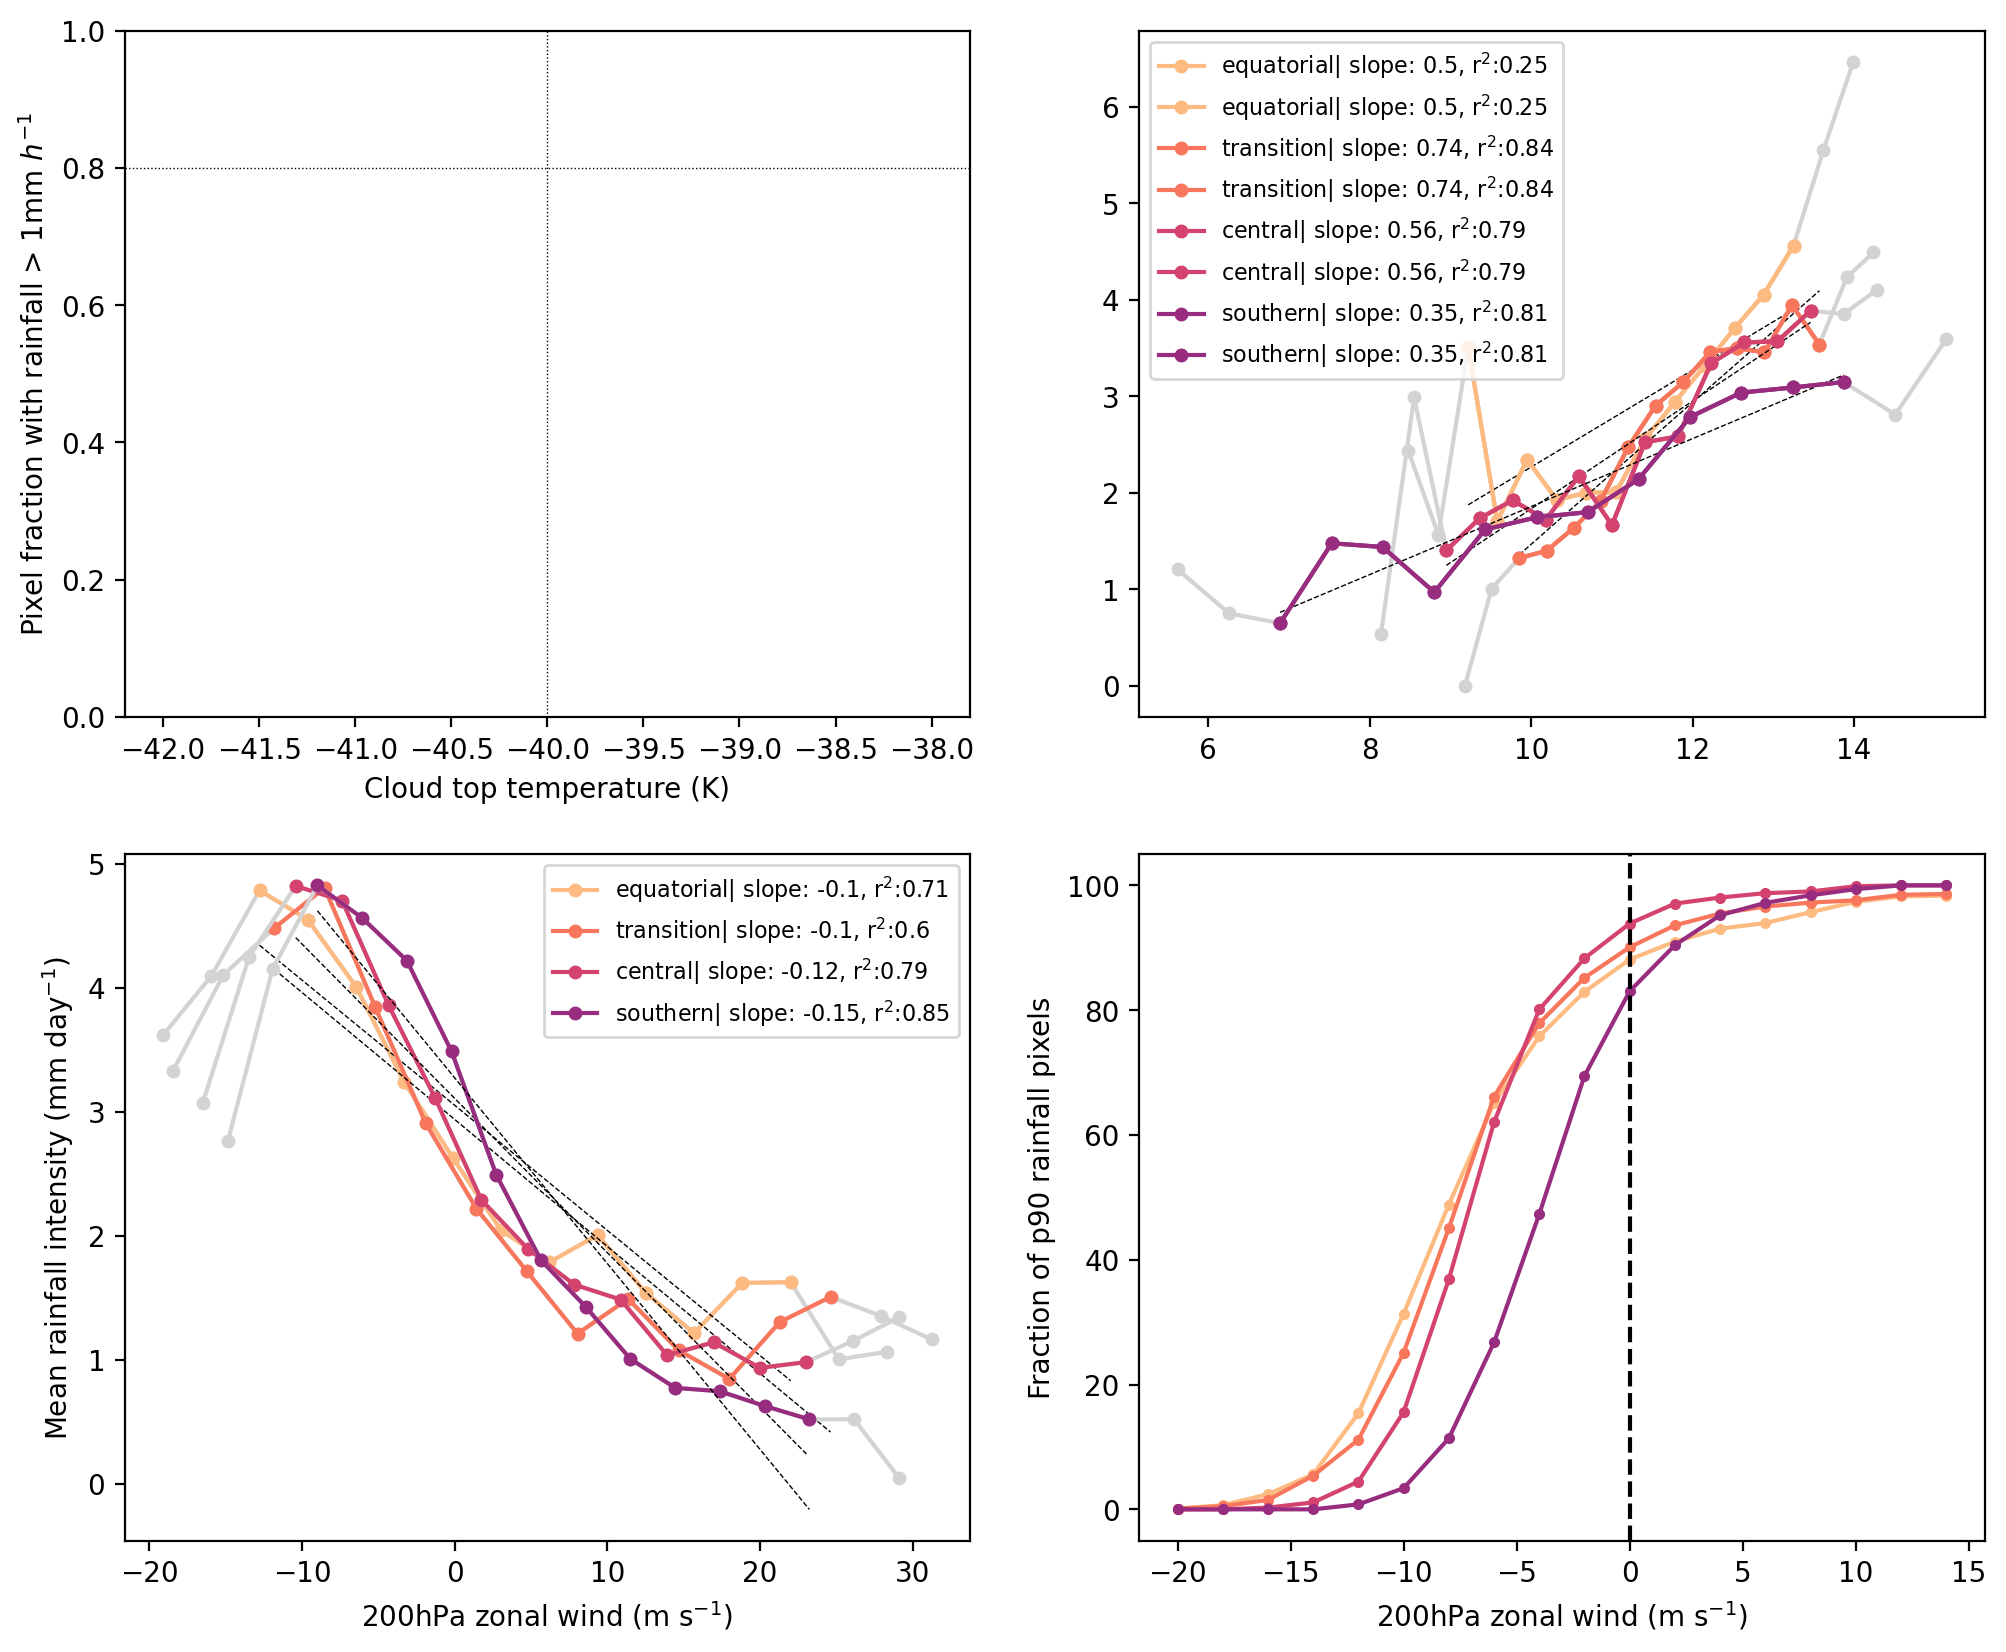

In [26]:
from endgame import hist2d

f = plt.figure(figsize=(12,10), dpi=200)
#ax = f.add_subplot(2,2,ids+1)
ax2 = f.add_subplot(221)
ax4 = f.add_subplot(222)
ax = f.add_subplot(223)
ax3 = f.add_subplot(224)
#ax3 = f.add_subplot(133)
for ids, r in enumerate(regions.keys()):
    
    alls = regions[r]
    doys_s = np.round(alls[1][0])
    doys_e = np.round(alls[1][1])
    era_region = u200ca['u'].sel(latitude=slice(alls[0][0], alls[0][1]), time =((u200ca['time.dayofyear']>=doys_s) | (u200ca['time.dayofyear']<=doys_e))).where((topo_on_g>2000)).mean(['latitude', 'longitude'])
    chirps_region = cau200.sel(latitude=slice(alls[0][0], alls[0][1]), time =((cau200['time.dayofyear']>=doys_s) | (cau200['time.dayofyear']<=doys_e))).where((topo_on_g>2000)).mean(['latitude', 'longitude'])
    
    era_region_gr = u200gr.sel(latitude=slice(alls[0][0], alls[0][1]), time =((u200gr['time.dayofyear']>=doys_s) | (u200gr['time.dayofyear']<=doys_e))).where((topo_on_g>2000)).mean(['latitude', 'longitude'])
    grid_region = grid200.sel(latitude=slice(alls[0][0], alls[0][1]), time =((grid200['time.dayofyear']>=doys_s) | (grid200['time.dayofyear']<=doys_e))).where((topo_on_g>2000)).mean(['latitude', 'longitude'])
    
    erav_region = v850ca['v'].sel(latitude=slice(alls[0][0], alls[0][1]), longitude=slice(lonsample[ids][0], lonsample[ids][1]), time =((v850ca['time.dayofyear']>=doys_s) | (v850ca['time.dayofyear']<=doys_e))).where((topo_on_g<1500)).mean(['latitude', 'longitude'])
    eraq_region = q850ca['q'].sel(latitude=slice(alls[0][0], alls[0][1]), longitude=slice(lonsample[ids][0], lonsample[ids][1]), time =((q850ca['time.dayofyear']>=doys_s) | (q850ca['time.dayofyear']<=doys_e))).where((topo_on_g<1500)).mean(['latitude', 'longitude'])*1000
  
    mask = np.isfinite(era_region) #& (chirps_region > 0.01) 
    mask_gr = np.isfinite(era_region_gr) & (grid_region < -15)
    #xbins = np.arange(-18,19,2)
    #ipdb.set_trace()
    q1 = 0.1
    q2 = 99.9
    xbins = np.percentile(era_region.values[mask], [0.1]+list(np.arange(5,96,5))+[99.9])
    xbins = np.linspace(np.percentile(era_region.values[mask],q1) ,np.percentile(era_region.values[mask],q2),17)
    
    cbins = np.arange(-80,-10,2)#np.percentile(grid_region.values[mask_gr], [0.1]+list(np.arange(5,96,5))+[99.9])
    
    dic = hist2d.var2_binning_mean(era_region.values[mask],chirps_region.values[mask],xbins)
    chperc = np.percentile(era_region_gr.values[mask_gr], 90)
    dicgrid = hist2d.var2_binning_threshold(grid_region.values[mask_gr], era_region_gr.values[mask_gr], cbins, gt=1, lt=None)
    
    ax.plot(dic['xbins'], dic['y'], marker='o', markersize=4, color='lightgrey')
    
    stx = 2
    ste = -2
    
    intercept, slope, r_value,rpearson, ppearson = weighted_regress(dic['xbins'][stx:ste],dic['y'][stx:ste],dic['ycount'][stx:ste] )
    ax.plot(dic['xbins'][stx:ste], dic['y'][stx:ste], label=r+'| slope: '+str(np.round(slope,2))+r', r$^2$:'+str(np.round(r_value**2,2)), marker='o', markersize=4, color=colord[ids])
    ax.plot(dic['xbins'][stx:ste],slope*(dic['xbins'][stx:ste])+intercept, linestyle='dashed', color='k', linewidth=0.5)
    
    #######################
  
    #xbins = np.percentile(eraq_region.values[mask], [0.1]+list(np.arange(5,96,5))+[99.9])
    
    xbins = np.linspace(8,14.5,17)
    mask = np.isfinite(eraq_region) 
    xbins = np.linspace(np.percentile(eraq_region.values[mask],q1) ,np.percentile(eraq_region.values[mask],q2),17)
    dic = hist2d.var2_binning_mean(eraq_region.values[mask],chirps_region.values[mask],xbins)
    ax4.plot(dic['xbins'], dic['y'], marker='o', markersize=4, color='lightgrey')
    stx = 2
    ste = -2
    
    intercept, slope, r_value,rpearson, ppearson = weighted_regress(dic['xbins'][stx:ste],dic['y'][stx:ste],dic['ycount'][stx:ste] )
    ax4.plot(dic['xbins'][stx:ste], dic['y'][stx:ste], label=r+'| slope: '+str(np.round(slope,2))+r', r$^2$:'+str(np.round(r_value**2,2)), marker='o', markersize=4, color=colord[ids])
    ax4.plot(dic['xbins'][stx:ste],slope*(dic['xbins'][stx:ste])+intercept, linestyle='dashed', color='k', linewidth=0.5)
    
    ax4.plot(dic['xbins'][stx:ste], dic['y'][stx:ste], label=r+'| slope: '+str(np.round(slope,2))+r', r$^2$:'+str(np.round(r_value**2,2)), marker='o', markersize=4, color=colord[ids])
    
    ####################
    


    ax.set_xlabel('200hPa zonal wind (m s$^{-1}$)')
    ax2.set_xlabel('Cloud top temperature (K)')
    ax.set_ylabel('Mean rainfall intensity (mm day$^{-1}$)')
    ax2.set_ylabel('Pixel fraction with rainfall > 1mm $h^{-1}$')
    
    cbins = np.arange(-20,15.1,2)
    dicgrid = hist2d.var2_binning_threshold_CDF(era_region.values[mask],chirps_region.values[mask], cbins, gt=np.percentile(chirps_region.values[mask],90))
    ax3.plot(dicgrid['xbins'], np.array(dicgrid['y'])*100, marker='o', markersize=3, color=colord[ids])
    
    ax3.set_xlabel('200hPa zonal wind (m s$^{-1}$)')
    ax3.set_ylabel('Fraction of p90 rainfall pixels')
    
    
ax.legend(fontsize=8)
ax4.legend(fontsize=8)
ax2.axvline(-40, linestyle='dotted', linewidth=0.5, color='k')
ax2.axhline(0.8, linestyle='dotted', linewidth=0.5, color='k')
ax3.axvline(0, linestyle='dashed', color='k')
#ax2.legend(fontsize=8)
#ax2.set_ylim(-50,-25)
#ax3.legend()
#plt.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/paper/figS01.jpg')

/home/ck/pythonWorkspace/proj_CEH/endgame/hist2d.py:437: RuntimeWarning: invalid value encountered in true_divide
  outdic['y'].append(np.sum(yvar[mask]>gt)/float(np.sum(np.isfinite(yvar[mask]))))
/home/ck/pythonWorkspace/proj_CEH/endgame/hist2d.py:437: RuntimeWarning: invalid value encountered in true_divide
  outdic['y'].append(np.sum(yvar[mask]>gt)/float(np.sum(np.isfinite(yvar[mask]))))
/home/ck/pythonWorkspace/proj_CEH/endgame/hist2d.py:437: RuntimeWarning: invalid value encountered in true_divide
  outdic['y'].append(np.sum(yvar[mask]>gt)/float(np.sum(np.isfinite(yvar[mask]))))
/home/ck/pythonWorkspace/proj_CEH/endgame/hist2d.py:437: RuntimeWarning: invalid value encountered in true_divide
  outdic['y'].append(np.sum(yvar[mask]>gt)/float(np.sum(np.isfinite(yvar[mask]))))


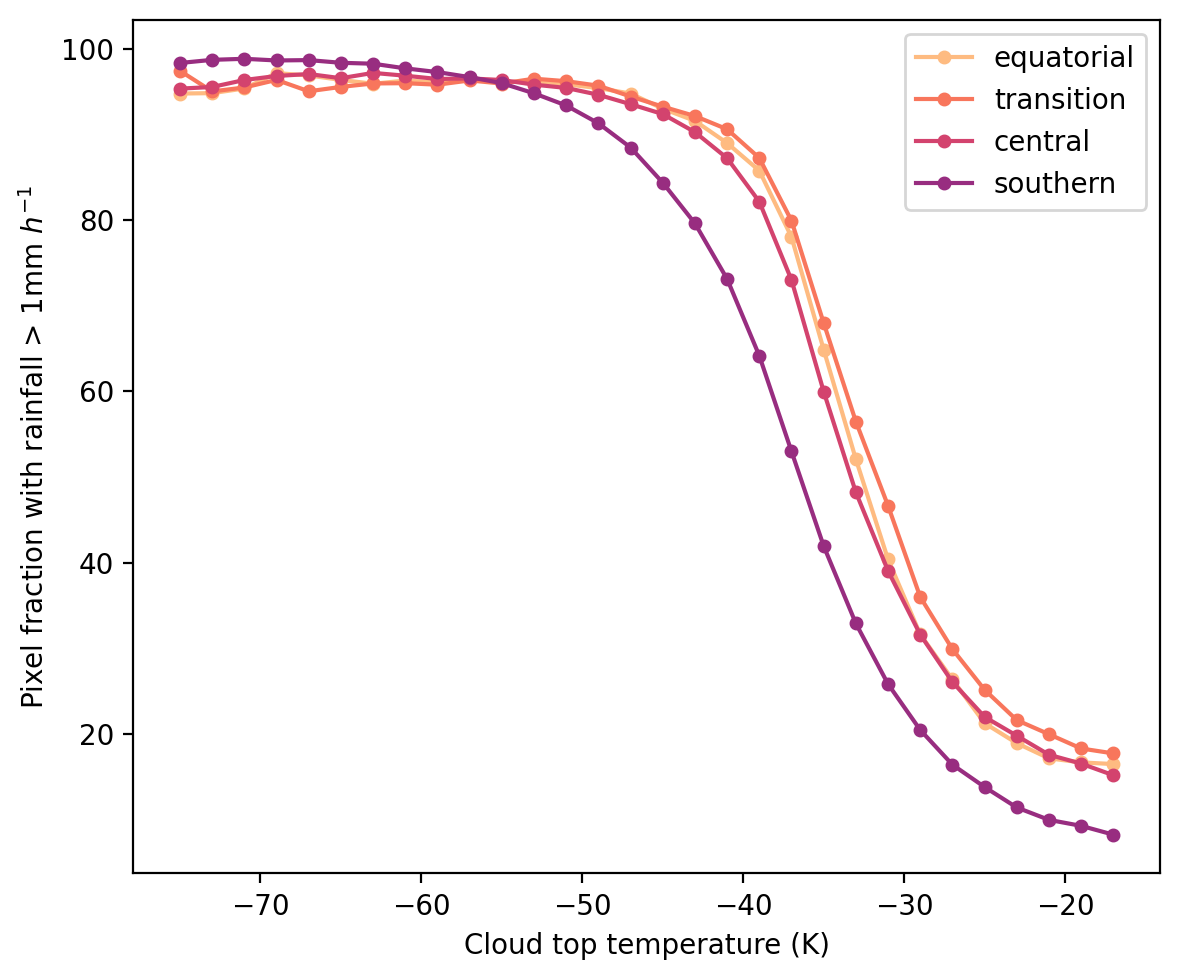

In [31]:
from endgame import hist2d

f = plt.figure(figsize=(6,5), dpi=200)
#ax = f.add_subplot(2,2,ids+1)
ax2 = f.add_subplot(111)

for ids, r in enumerate(regions.keys()):
    
    alls = regions[r]
    doys_s = np.round(alls[1][0])
    doys_e = np.round(alls[1][1])
    era_region = u200ca['u'].sel(latitude=slice(alls[0][0], alls[0][1]), time =((u200ca['time.dayofyear']>=doys_s) | (u200ca['time.dayofyear']<=doys_e))).where((topo_on_g>2000))
    chirps_region = cau200.sel(latitude=slice(alls[0][0], alls[0][1]), time =((cau200['time.dayofyear']>=doys_s) | (cau200['time.dayofyear']<=doys_e))).where((topo_on_g>2000))
    
    era_region_gr = u200gr.sel(latitude=slice(alls[0][0], alls[0][1]), time =((u200gr['time.dayofyear']>=doys_s) | (u200gr['time.dayofyear']<=doys_e))).where((topo_on_g>2000))
    grid_region = grid200.sel(latitude=slice(alls[0][0], alls[0][1]), time =((grid200['time.dayofyear']>=doys_s) | (grid200['time.dayofyear']<=doys_e))).where((topo_on_g>2000))

    mask = np.isfinite(era_region) #& (chirps_region > 0.01) 
    mask_gr = np.isfinite(era_region_gr) & (grid_region < -15)
    #xbins = np.arange(-18,19,2)
    #ipdb.set_trace()
    xbins = np.percentile(era_region.values[mask], [0.1]+list(np.arange(5,96,5))+[99.9])
    
    cbins = np.arange(-80,-10,2)#np.percentile(grid_region.values[mask_gr], [0.1]+list(np.arange(5,96,5))+[99.9])
    
    dic = hist2d.var2_binning_mean(era_region.values[mask],chirps_region.values[mask],xbins)
    chperc = np.percentile(era_region_gr.values[mask_gr], 90)
    dicgrid = hist2d.var2_binning_threshold(grid_region.values[mask_gr], era_region_gr.values[mask_gr], cbins, gt=1, lt=None)
    
    ax.plot(dic['xbins'], dic['y'], marker='o', markersize=4, color='lightgrey')
    
    stx = 2
    ste = -2
    
    intercept, slope, r_value,rpearson, ppearson = weighted_regress(dic['xbins'][stx:ste],dic['y'][stx:ste],dic['ycount'][stx:ste] )
    ax.plot(dic['xbins'][stx:ste], dic['y'][stx:ste], label=r+'| slope: '+str(np.round(slope,2)), marker='o', markersize=4, color=colord[ids])
    ax.plot(dic['xbins'][stx:ste],slope*(dic['xbins'][stx:ste])+intercept, linestyle='dashed', color='k', linewidth=0.5)
    

    ax2.plot(dicgrid['xbins'][stx:ste], np.array(dicgrid['y'][stx:ste])*100, label=r, marker='o', markersize=4, color=colord[ids])

    

    ax.set_xlabel('200hPa zonal wind (m s$^{-1}$)')
    ax2.set_xlabel('Cloud top temperature (K)')
    ax.set_ylabel('Mean rainfall intensity (mm day$^{-1}$)')
    ax2.set_ylabel('Pixel fraction with rainfall > 1mm $h^{-1}$')
    
plt.legend() 

plt.tight_layout()
f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/paper/cloudT_rainfall_wind_1mm.jpg')

/home/ck/pythonWorkspace/proj_CEH/endgame/hist2d.py:437: RuntimeWarning: invalid value encountered in true_divide
  outdic['y'].append(np.sum(yvar[mask]>gt)/float(np.sum(np.isfinite(yvar[mask]))))


90p 11.318272304534915
east wind vs rain >1mm frac 0.8343363423604145
easterly frac 0.719614823888958
Ratio 1.1594207271210395


/home/ck/pythonWorkspace/proj_CEH/endgame/hist2d.py:437: RuntimeWarning: invalid value encountered in true_divide
  outdic['y'].append(np.sum(yvar[mask]>gt)/float(np.sum(np.isfinite(yvar[mask]))))


90p 11.152390575408937
east wind vs rain >1mm frac 0.8153618550164549
easterly frac 0.6848945253641386
Ratio 1.1904925865525797


/home/ck/pythonWorkspace/proj_CEH/endgame/hist2d.py:437: RuntimeWarning: invalid value encountered in true_divide
  outdic['y'].append(np.sum(yvar[mask]>gt)/float(np.sum(np.isfinite(yvar[mask]))))


90p 10.128667354583744
east wind vs rain >1mm frac 0.7861170510247721
easterly frac 0.6617986464477692
Ratio 1.1878492880641067


/home/ck/pythonWorkspace/proj_CEH/endgame/hist2d.py:437: RuntimeWarning: invalid value encountered in true_divide
  outdic['y'].append(np.sum(yvar[mask]>gt)/float(np.sum(np.isfinite(yvar[mask]))))


90p 8.153028774261475
east wind vs rain >1mm frac 0.5819612507853487
easterly frac 0.42829899085126627
Ratio 1.3587733410920972


Text(0, 4, 'c)')

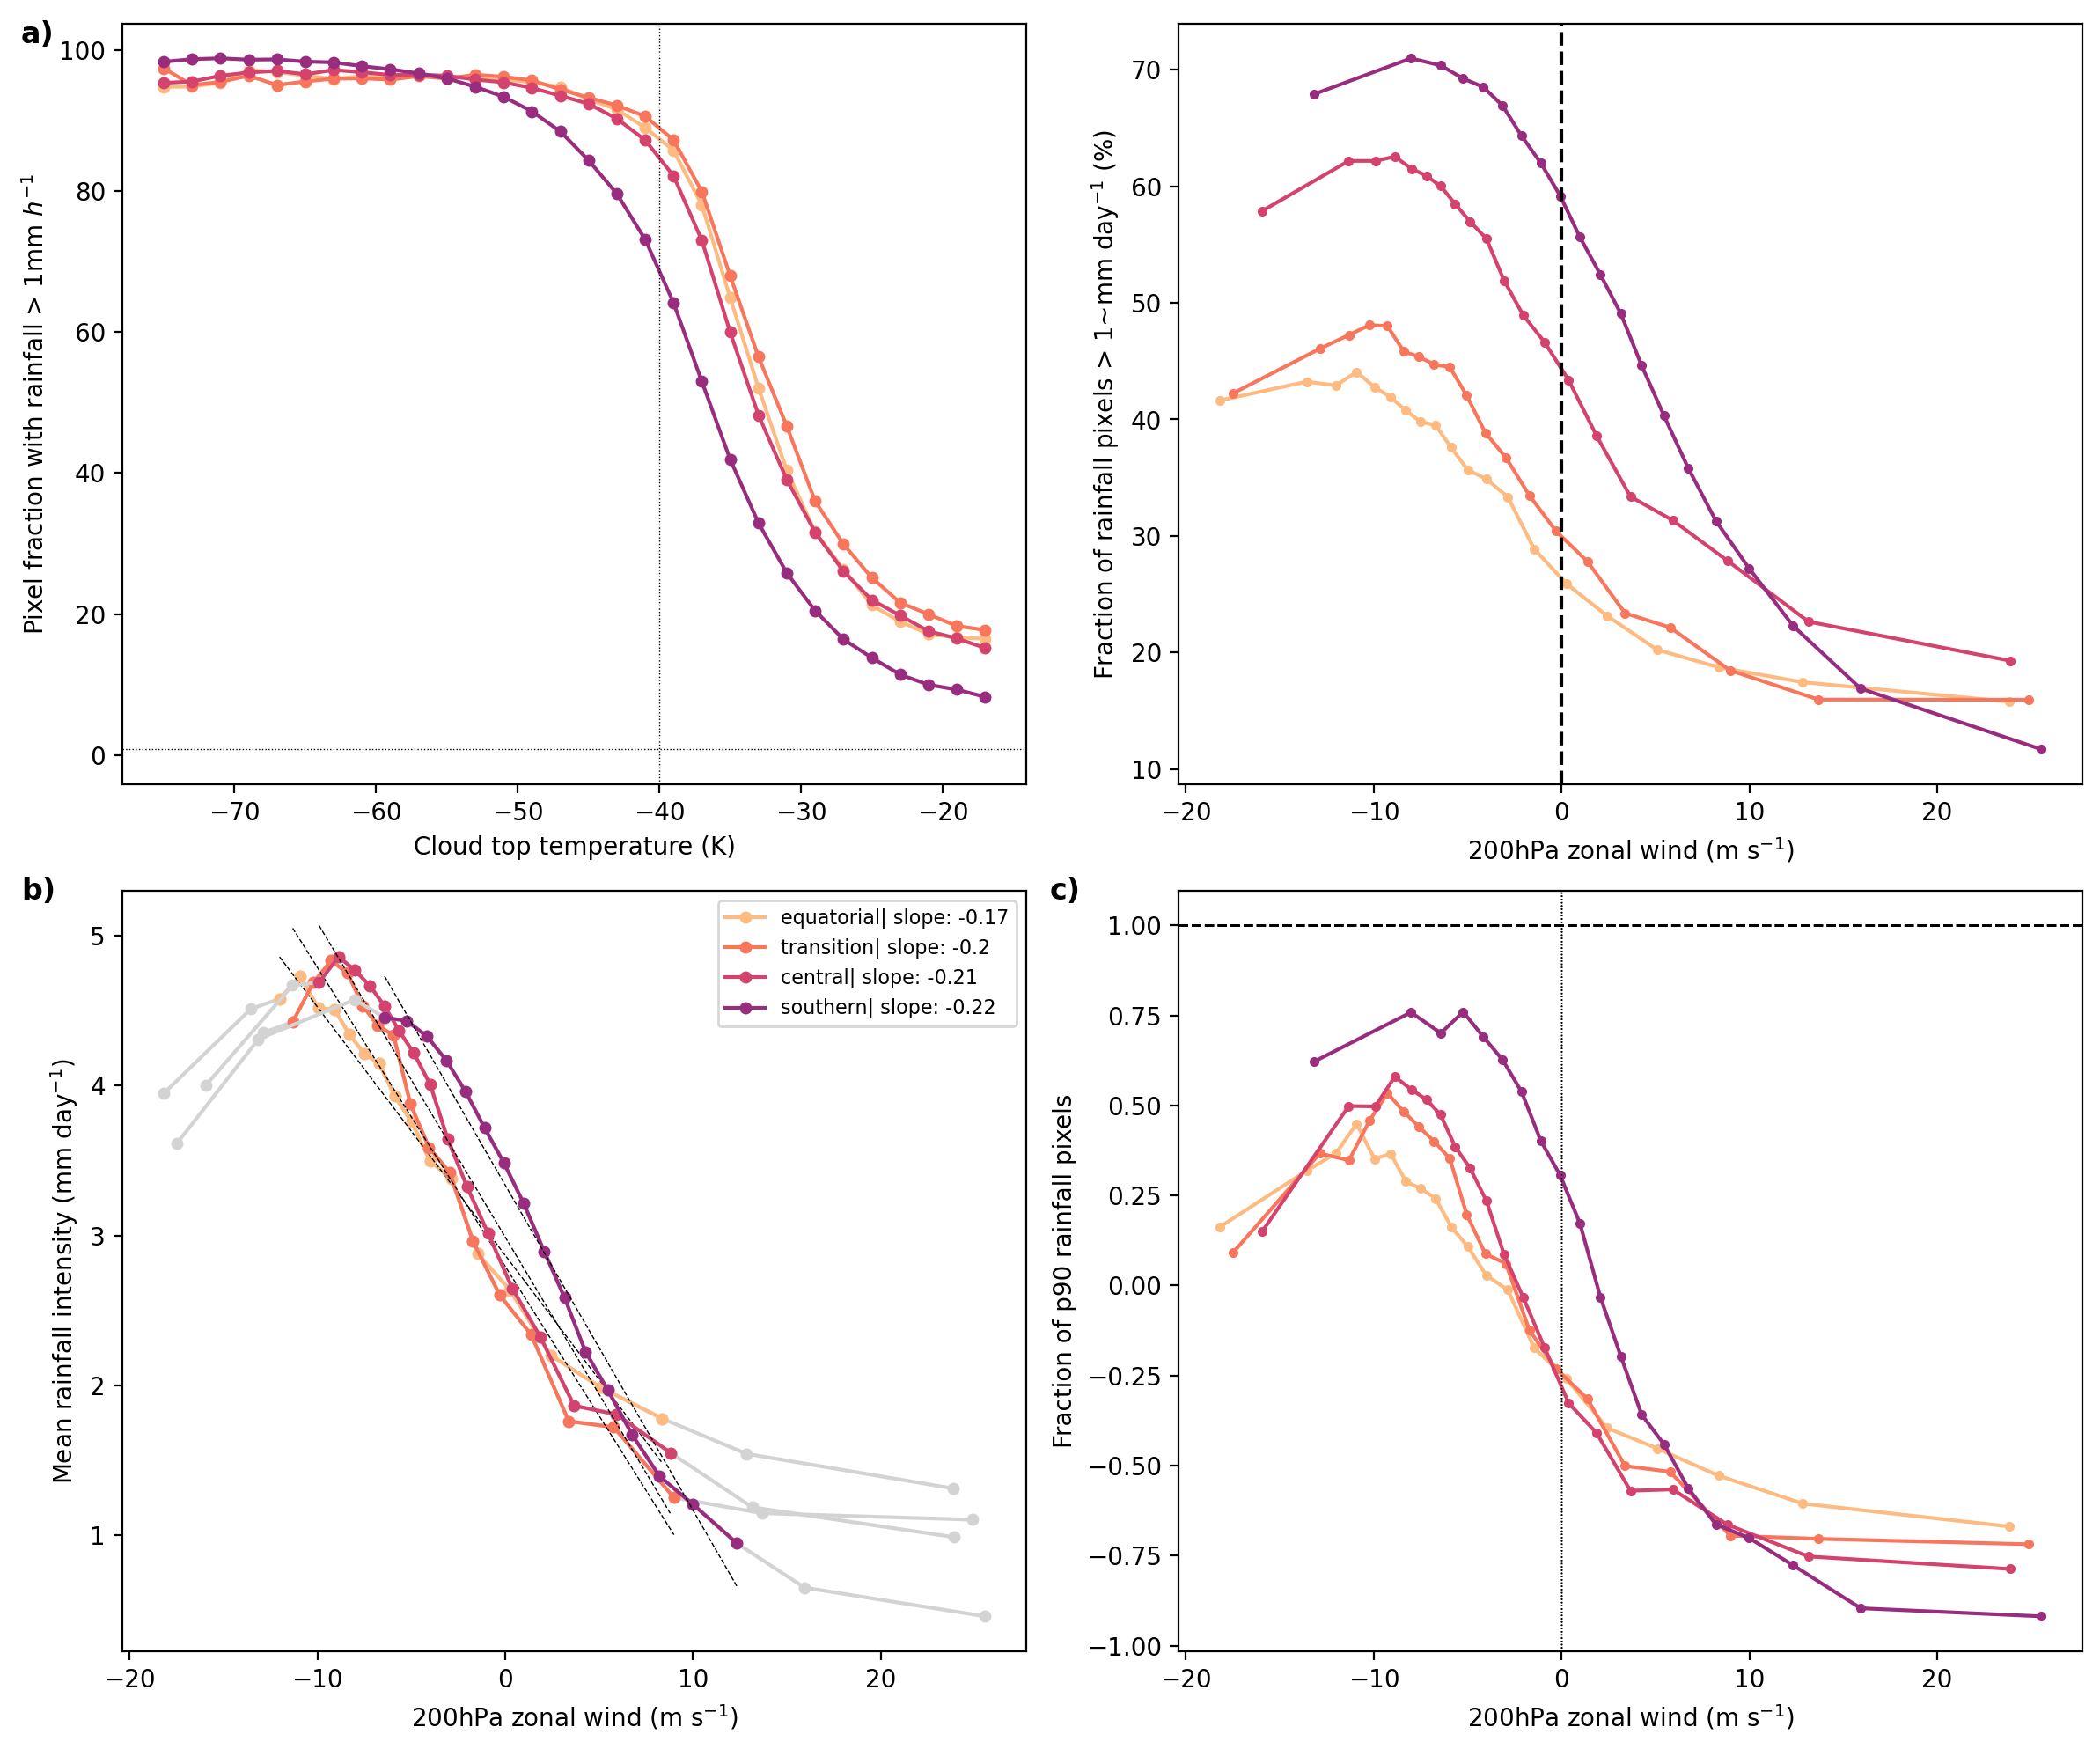

In [27]:
from endgame import hist2d

f = plt.figure(figsize=(12,10), dpi=200)
#ax = f.add_subplot(2,2,ids+1)
ax2 = f.add_subplot(221)
ax4 = f.add_subplot(224)
ax = f.add_subplot(223)
ax3 = f.add_subplot(222)
#ax3 = f.add_subplot(133)
for ids, r in enumerate(regions.keys()):
    
    alls = regions[r]
    doys_s = np.round(alls[1][0])
    doys_e = np.round(alls[1][1])
    era_region = u200ca['u'].sel(latitude=slice(alls[0][0], alls[0][1]), time =((u200ca['time.dayofyear']>=doys_s) | (u200ca['time.dayofyear']<=doys_e))).where((topo_on_g>2000))
    chirps_region = cau200.sel(latitude=slice(alls[0][0], alls[0][1]), time =((cau200['time.dayofyear']>=doys_s) | (cau200['time.dayofyear']<=doys_e))).where((topo_on_g>2000))
    
    era_region_gr = u200gr.sel(latitude=slice(alls[0][0], alls[0][1]), time =((u200gr['time.dayofyear']>=doys_s) | (u200gr['time.dayofyear']<=doys_e))).where((topo_on_g>2000))
    grid_region = grid200.sel(latitude=slice(alls[0][0], alls[0][1]), time =((grid200['time.dayofyear']>=doys_s) | (grid200['time.dayofyear']<=doys_e))).where((topo_on_g>2000))

    mask = np.isfinite(era_region) #& (chirps_region > 0.01) 
    mask_gr = np.isfinite(era_region_gr) & (grid_region < -15)
    #xbins = np.arange(-18,19,2)
    #ipdb.set_trace()
    xbins = np.percentile(era_region.values[mask], [0.1]+list(np.arange(5,96,5))+[99.9])
    
    cbins = np.arange(-80,-10,2)#np.percentile(grid_region.values[mask_gr], [0.1]+list(np.arange(5,96,5))+[99.9])
    
    dic = hist2d.var2_binning_mean(era_region.values[mask],chirps_region.values[mask],xbins)
    chperc = np.percentile(era_region_gr.values[mask_gr], 90)
    dicgrid = hist2d.var2_binning_threshold(grid_region.values[mask_gr], era_region_gr.values[mask_gr], cbins, gt=1, lt=None)
    
    ax.plot(dic['xbins'], dic['y'], marker='o', markersize=4, color='lightgrey')
    
    stx = 2
    ste = -2
    
    intercept, slope, r_value,rpearson, ppearson = weighted_regress(dic['xbins'][stx:ste],dic['y'][stx:ste],dic['ycount'][stx:ste] )
    ax.plot(dic['xbins'][stx:ste], dic['y'][stx:ste], label=r+'| slope: '+str(np.round(slope,2)), marker='o', markersize=4, color=colord[ids])
    ax.plot(dic['xbins'][stx:ste],slope*(dic['xbins'][stx:ste])+intercept, linestyle='dashed', color='k', linewidth=0.5)
    

    ax2.plot(dicgrid['xbins'][stx:ste], np.array(dicgrid['y'][stx:ste])*100, label=r+' | slope: '+str(np.round(slope,2)), marker='o', markersize=4, color=colord[ids])

    

    ax.set_xlabel('200hPa zonal wind (m s$^{-1}$)')
    ax2.set_xlabel('Cloud top temperature (K)')
    ax.set_ylabel('Mean rainfall intensity (mm day$^{-1}$)')
    ax2.set_ylabel('Pixel fraction with rainfall > 1mm $h^{-1}$')
    
    
    cbins =  np.percentile(era_region.values[mask], [0.1]+list(np.arange(5,96,5))+[99.9]) #np.percentile(era_region.values[mask], np.arange(0,101,5))
    dicgrid = hist2d.var2_binning_threshold(era_region.values[mask],chirps_region.values[mask], cbins, gt=1, lt=None)
    
    ax3.plot(dicgrid['xbins'], np.array(dicgrid['y'])*100, marker='o', markersize=3, color=colord[ids])
    #ax3.plot(dicgrid['xbins'], np.arange(0,101,5), marker='o', markersize=3, color='k')
    
    ax3.set_xlabel('200hPa zonal wind (m s$^{-1}$)')
    ax3.set_ylabel('Fraction of rainfall pixels > 1~mm day$^{-1}$ (%)')
    
    

    dicgrid = hist2d.var2_binning_threshold_full(era_region.values[mask],chirps_region.values[mask], cbins, gt=10)  #np.percentile(chirps_region.values[mask],90)
    
    dicgridd2 = hist2d.var2_binning_threshold_full(era_region.values[mask],chirps_region.values[mask], cbins, gt=-1)
    
    
    #ipdb.set_trace()
    print('90p', np.percentile(chirps_region.values[mask],90))
    

    
    
    ax4.plot(dicgrid['xbins'], (np.array(dicgrid['y'])-np.array(dicgridd2['y']))/np.array(dicgridd2['y']), marker='o', markersize=3, color=colord[ids])
    
    ax4.axvline(0, linewidth=0.5, linestyle='dotted', color='k')
    
    ax4.axhline(1, linewidth=1, linestyle='dashed', color='k')
    
    ax4.set_xlabel('200hPa zonal wind (m s$^{-1}$)')
    ax4.set_ylabel('Fraction of p90 rainfall pixels')
    
    
    
    print('east wind vs rain >1mm frac', np.sum((chirps_region.values[mask]>=1) & (era_region.values[mask]<0)) / np.sum(chirps_region.values[mask]>=1))
       
    print('easterly frac',  np.sum((era_region.values[mask]<0)) / np.sum(np.isfinite(era_region.values[mask])))
    
    print('Ratio', ( np.sum((chirps_region.values[mask]>=1) & (era_region.values[mask]<0)) / np.sum(chirps_region.values[mask]>=1)) / ( np.sum((era_region.values[mask]<0)) / np.sum(np.isfinite(era_region.values[mask]))))
    
    
    
ax.legend(fontsize=8)
ax2.axvline(-40, linestyle='dotted', linewidth=0.5, color='k')
ax2.axhline(0.8, linestyle='dotted', linewidth=0.5, color='k')
ax3.axvline(0, linestyle='dashed', color='k')
#ax2.legend(fontsize=8)
#ax2.set_ylim(-50,-25)
#ax3.legend()
#plt.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/paper/figS01.jpg')

plt.tight_layout()
plt.annotate('a)', xy=(0.01, 0.97), xytext=(0, 4), size=12, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points', fontweight='bold')
plt.annotate('b)', xy=(0.01, 0.48), xytext=(0, 4), size=12, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points', fontweight='bold')

plt.annotate('c)', xy=(0.5, 0.48), xytext=(0, 4), size=12, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points', fontweight='bold')

#f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/paper/cloudT_rainfall_wind_1mm.jpg')

/home/ck/pythonWorkspace/proj_CEH/endgame/hist2d.py:437: RuntimeWarning: invalid value encountered in true_divide
  outdic['y'].append(np.sum(yvar[mask]>gt)/float(np.sum(np.isfinite(yvar[mask]))))


90p 11.318272304534915
east wind vs rain >1mm frac 0.8343363423604145
easterly frac 0.719614823888958
Ratio 1.1594207271210395


/home/ck/pythonWorkspace/proj_CEH/endgame/hist2d.py:437: RuntimeWarning: invalid value encountered in true_divide
  outdic['y'].append(np.sum(yvar[mask]>gt)/float(np.sum(np.isfinite(yvar[mask]))))


90p 11.152390575408937
east wind vs rain >1mm frac 0.8153618550164549
easterly frac 0.6848945253641386
Ratio 1.1904925865525797


/home/ck/pythonWorkspace/proj_CEH/endgame/hist2d.py:437: RuntimeWarning: invalid value encountered in true_divide
  outdic['y'].append(np.sum(yvar[mask]>gt)/float(np.sum(np.isfinite(yvar[mask]))))


90p 10.128667354583744
east wind vs rain >1mm frac 0.7861170510247721
easterly frac 0.6617986464477692
Ratio 1.1878492880641067


/home/ck/pythonWorkspace/proj_CEH/endgame/hist2d.py:437: RuntimeWarning: invalid value encountered in true_divide
  outdic['y'].append(np.sum(yvar[mask]>gt)/float(np.sum(np.isfinite(yvar[mask]))))


90p 8.153028774261475
east wind vs rain >1mm frac 0.5819612507853487
easterly frac 0.42829899085126627
Ratio 1.3587733410920972


Text(0, 4, 'c)')

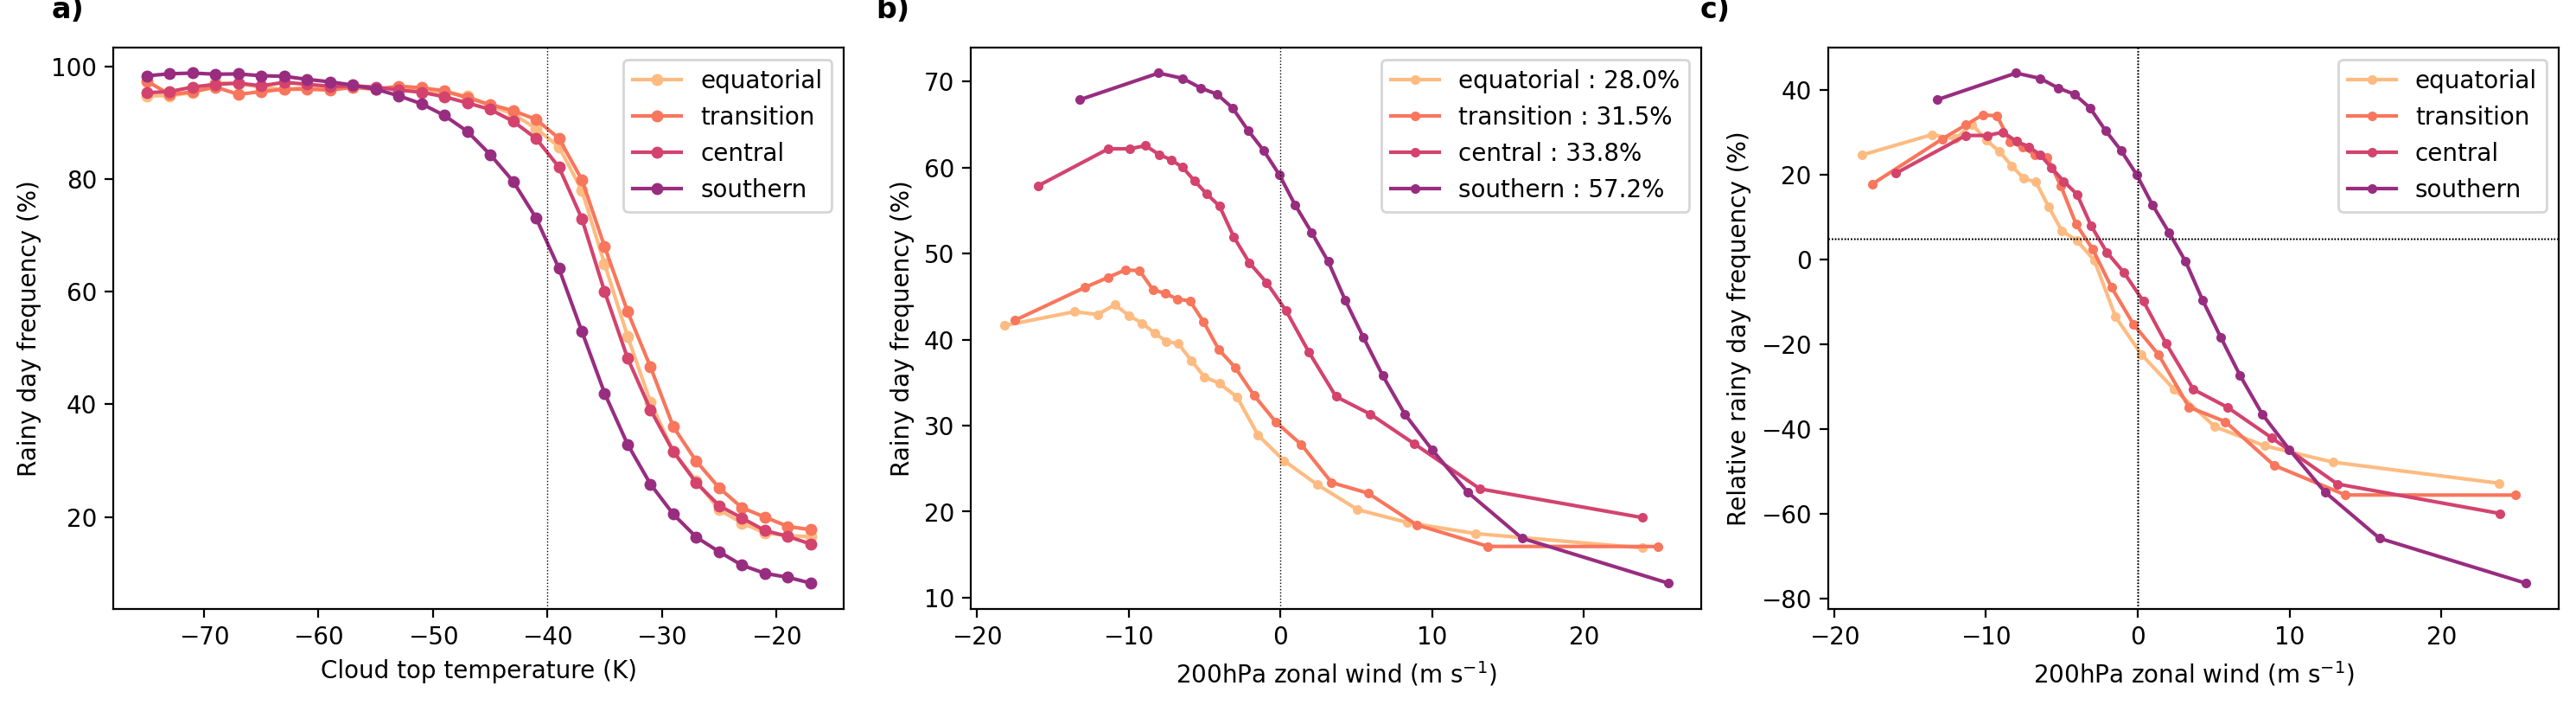

In [28]:
from endgame import hist2d

f = plt.figure(figsize=(15,4), dpi=200)
#ax = f.add_subplot(2,2,ids+1)
ax2 = f.add_subplot(131)
ax4 = f.add_subplot(133)
#ax = f.add_subplot(223)
ax3 = f.add_subplot(132)
#ax3 = f.add_subplot(133)
for ids, r in enumerate(regions.keys()):
    
    alls = regions[r]
    doys_s = np.round(alls[1][0])
    doys_e = np.round(alls[1][1])
    era_region = u200ca['u'].sel(latitude=slice(alls[0][0], alls[0][1]), time =((u200ca['time.dayofyear']>=doys_s) | (u200ca['time.dayofyear']<=doys_e))).where((topo_on_g>2000))
    chirps_region = cau200.sel(latitude=slice(alls[0][0], alls[0][1]), time =((cau200['time.dayofyear']>=doys_s) | (cau200['time.dayofyear']<=doys_e))).where((topo_on_g>2000))
    
    era_region_gr = u200gr.sel(latitude=slice(alls[0][0], alls[0][1]), time =((u200gr['time.dayofyear']>=doys_s) | (u200gr['time.dayofyear']<=doys_e))).where((topo_on_g>2000))
    grid_region = grid200.sel(latitude=slice(alls[0][0], alls[0][1]), time =((grid200['time.dayofyear']>=doys_s) | (grid200['time.dayofyear']<=doys_e))).where((topo_on_g>2000))

    mask = np.isfinite(era_region) #& (chirps_region > 0.01) 
    mask_gr = np.isfinite(era_region_gr) & (grid_region < -15)
    #xbins = np.arange(-18,19,2)
    #ipdb.set_trace()
    xbins = np.percentile(era_region.values[mask], [0.1]+list(np.arange(5,96,5))+[99.9])
    
    cbins = np.arange(-80,-10,2)#np.percentile(grid_region.values[mask_gr], [0.1]+list(np.arange(5,96,5))+[99.9])
    
#     dic = hist2d.var2_binning_mean(era_region.values[mask],chirps_region.values[mask],xbins)
    chperc = np.percentile(era_region_gr.values[mask_gr], 90)
    dicgrid = hist2d.var2_binning_threshold(grid_region.values[mask_gr], era_region_gr.values[mask_gr], cbins, gt=1, lt=None)
    
#     ax.plot(dic['xbins'], dic['y'], marker='o', markersize=4, color='lightgrey')
    
    stx = 2
    ste = -2
    
#     intercept, slope, r_value,rpearson, ppearson = weighted_regress(dic['xbins'][stx:ste],dic['y'][stx:ste],dic['ycount'][stx:ste] )
#     ax.plot(dic['xbins'][stx:ste], dic['y'][stx:ste], label=r+'| slope: '+str(np.round(slope,2)), marker='o', markersize=4, color=colord[ids])
#     ax.plot(dic['xbins'][stx:ste],slope*(dic['xbins'][stx:ste])+intercept, linestyle='dashed', color='k', linewidth=0.5)
    

    ax2.plot(dicgrid['xbins'][stx:ste], np.array(dicgrid['y'][stx:ste])*100, marker='o', markersize=4, color=colord[ids], label=r)

    

    #ax.set_xlabel('200hPa zonal wind (m s$^{-1}$)')
    ax2.set_xlabel('Cloud top temperature (K)')
   # ax.set_ylabel('Mean rainfall intensity (mm day$^{-1}$)')
    ax2.set_ylabel('Rainy day frequency (%)')
    
    
    cbins =  np.percentile(era_region.values[mask], [0.1]+list(np.arange(5,96,5))+[99.9]) #np.percentile(era_region.values[mask], np.arange(0,101,5))
    dicgrid = hist2d.var2_binning_threshold(era_region.values[mask],chirps_region.values[mask], cbins, gt=1, lt=None)
    
    ax3.plot(dicgrid['xbins'], np.array(dicgrid['y'])*100, marker='o', markersize=3, color=colord[ids], label=r+' : '+str(np.round(np.sum(era_region.values[mask]>0) / np.sum(np.isfinite(era_region.values[mask]))*100, 1))+'%')
    #ax3.plot(dicgrid['xbins'], np.arange(0,101,5), marker='o', markersize=3, color='k')
    
    ax3.set_xlabel('200hPa zonal wind (m s$^{-1}$)')
    ax3.set_ylabel('Rainy day frequency (%)')
    
    

    dicgrid = hist2d.var2_binning_threshold_full(era_region.values[mask],chirps_region.values[mask], cbins, gt=1)  #np.percentile(chirps_region.values[mask],90)
    
    dicgridd2 = hist2d.var2_binning_threshold_full(era_region.values[mask],chirps_region.values[mask], cbins, gt=-1)
    
    
    #ipdb.set_trace()
    print('90p', np.percentile(chirps_region.values[mask],90))
    

    
    
    ax4.plot(dicgrid['xbins'], (np.array(dicgrid['y'])-np.array(dicgridd2['y']))/np.array(dicgridd2['y'])*100, marker='o', markersize=3, color=colord[ids], label=r)
    #ax4.plot(dicgrid['xbins'], (np.array(dicgrid['y'])/np.sum(dicgrid['y']))*100, marker='o', markersize=3, color=colord[ids], label=r)
    
    ax4.axvline(0, linewidth=0.5, linestyle='dotted', color='k') 
    ax4.axhline(5, linewidth=0.5, linestyle='dotted', color='k')
    
    ax4.set_xlabel('200hPa zonal wind (m s$^{-1}$)')
    ax4.set_ylabel('Relative rainy day frequency (%)')
    
    
    
    print('east wind vs rain >1mm frac', np.sum((chirps_region.values[mask]>=1) & (era_region.values[mask]<0)) / np.sum(chirps_region.values[mask]>=1))
       
    print('easterly frac',  np.sum((era_region.values[mask]<0)) / np.sum(np.isfinite(era_region.values[mask])))
    
    print('Ratio', ( np.sum((chirps_region.values[mask]>=1) & (era_region.values[mask]<0)) / np.sum(chirps_region.values[mask]>=1)) / ( np.sum((era_region.values[mask]<0)) / np.sum(np.isfinite(era_region.values[mask]))))
    
    
    
ax.legend(fontsize=8)
ax2.axvline(-40, linestyle='dotted', linewidth=0.5, color='k')
ax3.axvline(0, linestyle='dotted', color='k', linewidth=0.5)
#ax2.legend(fontsize=8)
#ax2.set_ylim(-50,-25)
ax2.legend()
ax3.legend()
ax4.legend()
#plt.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/paper/figS01.jpg')

plt.tight_layout()
plt.annotate('a)', xy=(0.02, 0.96), xytext=(0, 4), size=12, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points', fontweight='bold')
plt.annotate('b)', xy=(0.34, 0.96), xytext=(0, 4), size=12, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points', fontweight='bold')

plt.annotate('c)', xy=(0.66, 0.96), xytext=(0, 4), size=12, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points', fontweight='bold')

#f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/paper/cloudT_rainfall_wind_1mm_3x.jpg')

In [29]:
wd = np.rad2deg(np.arctan2(u200ca['u'], v850ca['v']))
ws = np.sqrt(v850ca['v']**2 + u200ca['u']**2)

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier inst

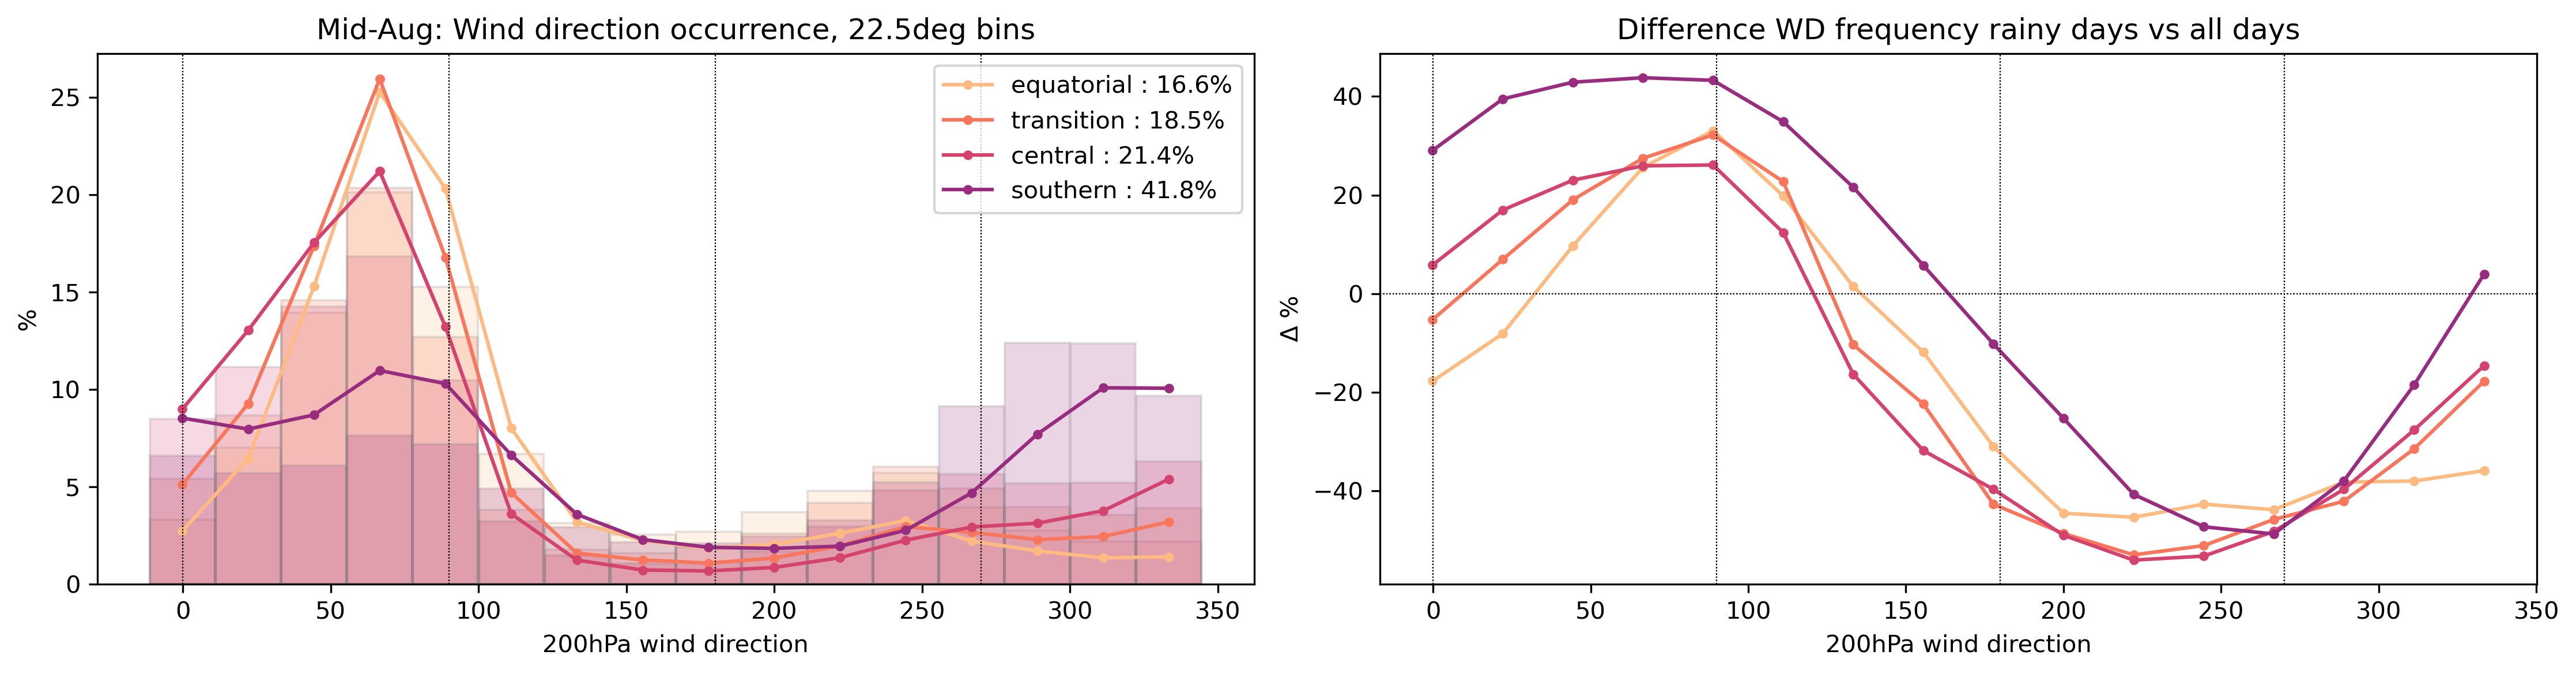

In [30]:
f = plt.figure(figsize = (15,4), dpi=300)

for ids, r in enumerate(regions.keys()):
    
    alls = regions[r]
    doys_s = np.round(alls[1][0])
    doys_e = np.round(alls[1][1])

    wdaug = wd.sel(latitude=slice(alls[0][0], alls[0][1]), time =((u200ca['time.dayofyear']>=doys_s) | (u200ca['time.dayofyear']<=doys_e))).where((topo_on_g>2000))+180-11.25
    wsaug = ws.sel(latitude=slice(alls[0][0], alls[0][1]), time =((u200ca['time.dayofyear']>=doys_s) | (u200ca['time.dayofyear']<=doys_e))).where((topo_on_g>2000))
    caaug = cau200.sel(latitude=slice(alls[0][0], alls[0][1]), time =((cau200['time.dayofyear']>=doys_s) | (cau200['time.dayofyear']<=doys_e))).where((topo_on_g>2000))
    era_region = u200ca['u'].sel(latitude=slice(alls[0][0], alls[0][1]), time =((u200ca['time.dayofyear']>=doys_s) | (u200ca['time.dayofyear']<=doys_e))).where((topo_on_g>2000))
    
    alim = 1
    mean, bins, binnb = stats.binned_statistic(wdaug.values.flatten(), ((caaug.values.flatten()>=alim)).astype(int), bins=np.arange(-11.25,361,22.24), statistic=np.nansum)
    mbins = bins[0:-1] + (bins[1::]-bins[0:-1])/2

    meanz, binsz, binnbz = stats.binned_statistic(wdaug.values.flatten(), (caaug.values.flatten()>=0).astype(int), bins=np.arange(-11.25,361,22.24), statistic=np.nansum)
    mbins = bins[0:-1] + (bins[1::]-bins[0:-1])/2


    ax = f.add_subplot(1,2,1)
#     plt.bar(mbins, meanz/np.sum(meanz)*100, width=(bins[1::]-bins[0:-1]-1), edgecolor='k', label='all day frequency', color='grey')
#     plt.bar(mbins, mean/np.sum(mean)*100, width=(bins[1::]-bins[0:-1]-1), edgecolor='k', label='rainy day frequency', color='lightblue', alpha=0.7)
    
    ax.plot(mbins,mean/np.sum(mean)*100, marker='o', markersize=3, color=colord[ids], label=r+' : '+str(np.round((np.sum((caaug.values>=1) & (era_region.values>0)) / np.sum((caaug.values>=1)))*100, 1))+'%')
    ax.bar(mbins,meanz/np.sum(meanz)*100, color=colord[ids], edgecolor='grey', alpha=0.2, width=22)
    
    plt.title('Mid-Aug: Wind direction occurrence, 22.5deg bins')
    ax.axvline(90, color='k', linewidth=0.5, linestyle='dotted')
    ax.axvline(180, color='k', linewidth=0.5, linestyle='dotted')
    ax.axvline(270, color='k', linewidth=0.5, linestyle='dotted')
    ax.axvline(0, color='k', linewidth=0.5, linestyle='dotted')

    ax.set_ylabel('%')
    ax.set_xlabel('200hPa wind direction')
    plt.legend()

    ax = f.add_subplot(1,2,2)
    cbars = ['lightblue']*16
    dat = ((mean/np.sum(mean) - meanz/np.sum(meanz))/(meanz/np.sum(meanz)))*100
    
    bposi = np.where(dat < 0)
    cbars = np.array(cbars)
    cbars[bposi] = 'tomato'

    #plt.bar(mbins,dat , width=(bins[1::]-bins[0:-1]-1), edgecolor='k', color=cbars)
    
    ax.plot(mbins,dat, marker='o', markersize=3, color=colord[ids])
    
    #plt.bar(mbins, mean/np.sum(mean), width=(bins[1::]-bins[0:-1]), edgecolor='k')
    plt.title('Difference WD frequency rainy days vs all days')
    ax.axvline(90, color='k', linewidth=0.5, linestyle='dotted')
    ax.axvline(180, color='k', linewidth=0.5, linestyle='dotted')
    ax.axvline(270, color='k', linewidth=0.5, linestyle='dotted')
    ax.axvline(0, color='k', linewidth=0.5, linestyle='dotted')
    ax.axhline(0, color='k', linewidth=0.5, linestyle='dotted')

    ax.set_ylabel(r'$\Delta$ %')
    ax.set_xlabel('200hPa wind direction')
plt.tight_layout()
#f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/histo_GRIDSAT_Aug-Sep_RD1mm_topo_topoLT4500_22.5deg_GT-20.jpg')

/home/ck/pythonWorkspace/proj_CEH/endgame/hist2d.py:437: RuntimeWarning: invalid value encountered in true_divide
  outdic['y'].append(np.sum(yvar[mask]>gt)/float(np.sum(np.isfinite(yvar[mask]))))
/home/ck/pythonWorkspace/proj_CEH/endgame/hist2d.py:437: RuntimeWarning: invalid value encountered in true_divide
  outdic['y'].append(np.sum(yvar[mask]>gt)/float(np.sum(np.isfinite(yvar[mask]))))
/home/ck/pythonWorkspace/proj_CEH/endgame/hist2d.py:437: RuntimeWarning: invalid value encountered in true_divide
  outdic['y'].append(np.sum(yvar[mask]>gt)/float(np.sum(np.isfinite(yvar[mask]))))
/home/ck/pythonWorkspace/proj_CEH/endgame/hist2d.py:437: RuntimeWarning: invalid value encountered in true_divide
  outdic['y'].append(np.sum(yvar[mask]>gt)/float(np.sum(np.isfinite(yvar[mask]))))
No handles with labels found to put in legend.
No handles with labels found to put in legend.


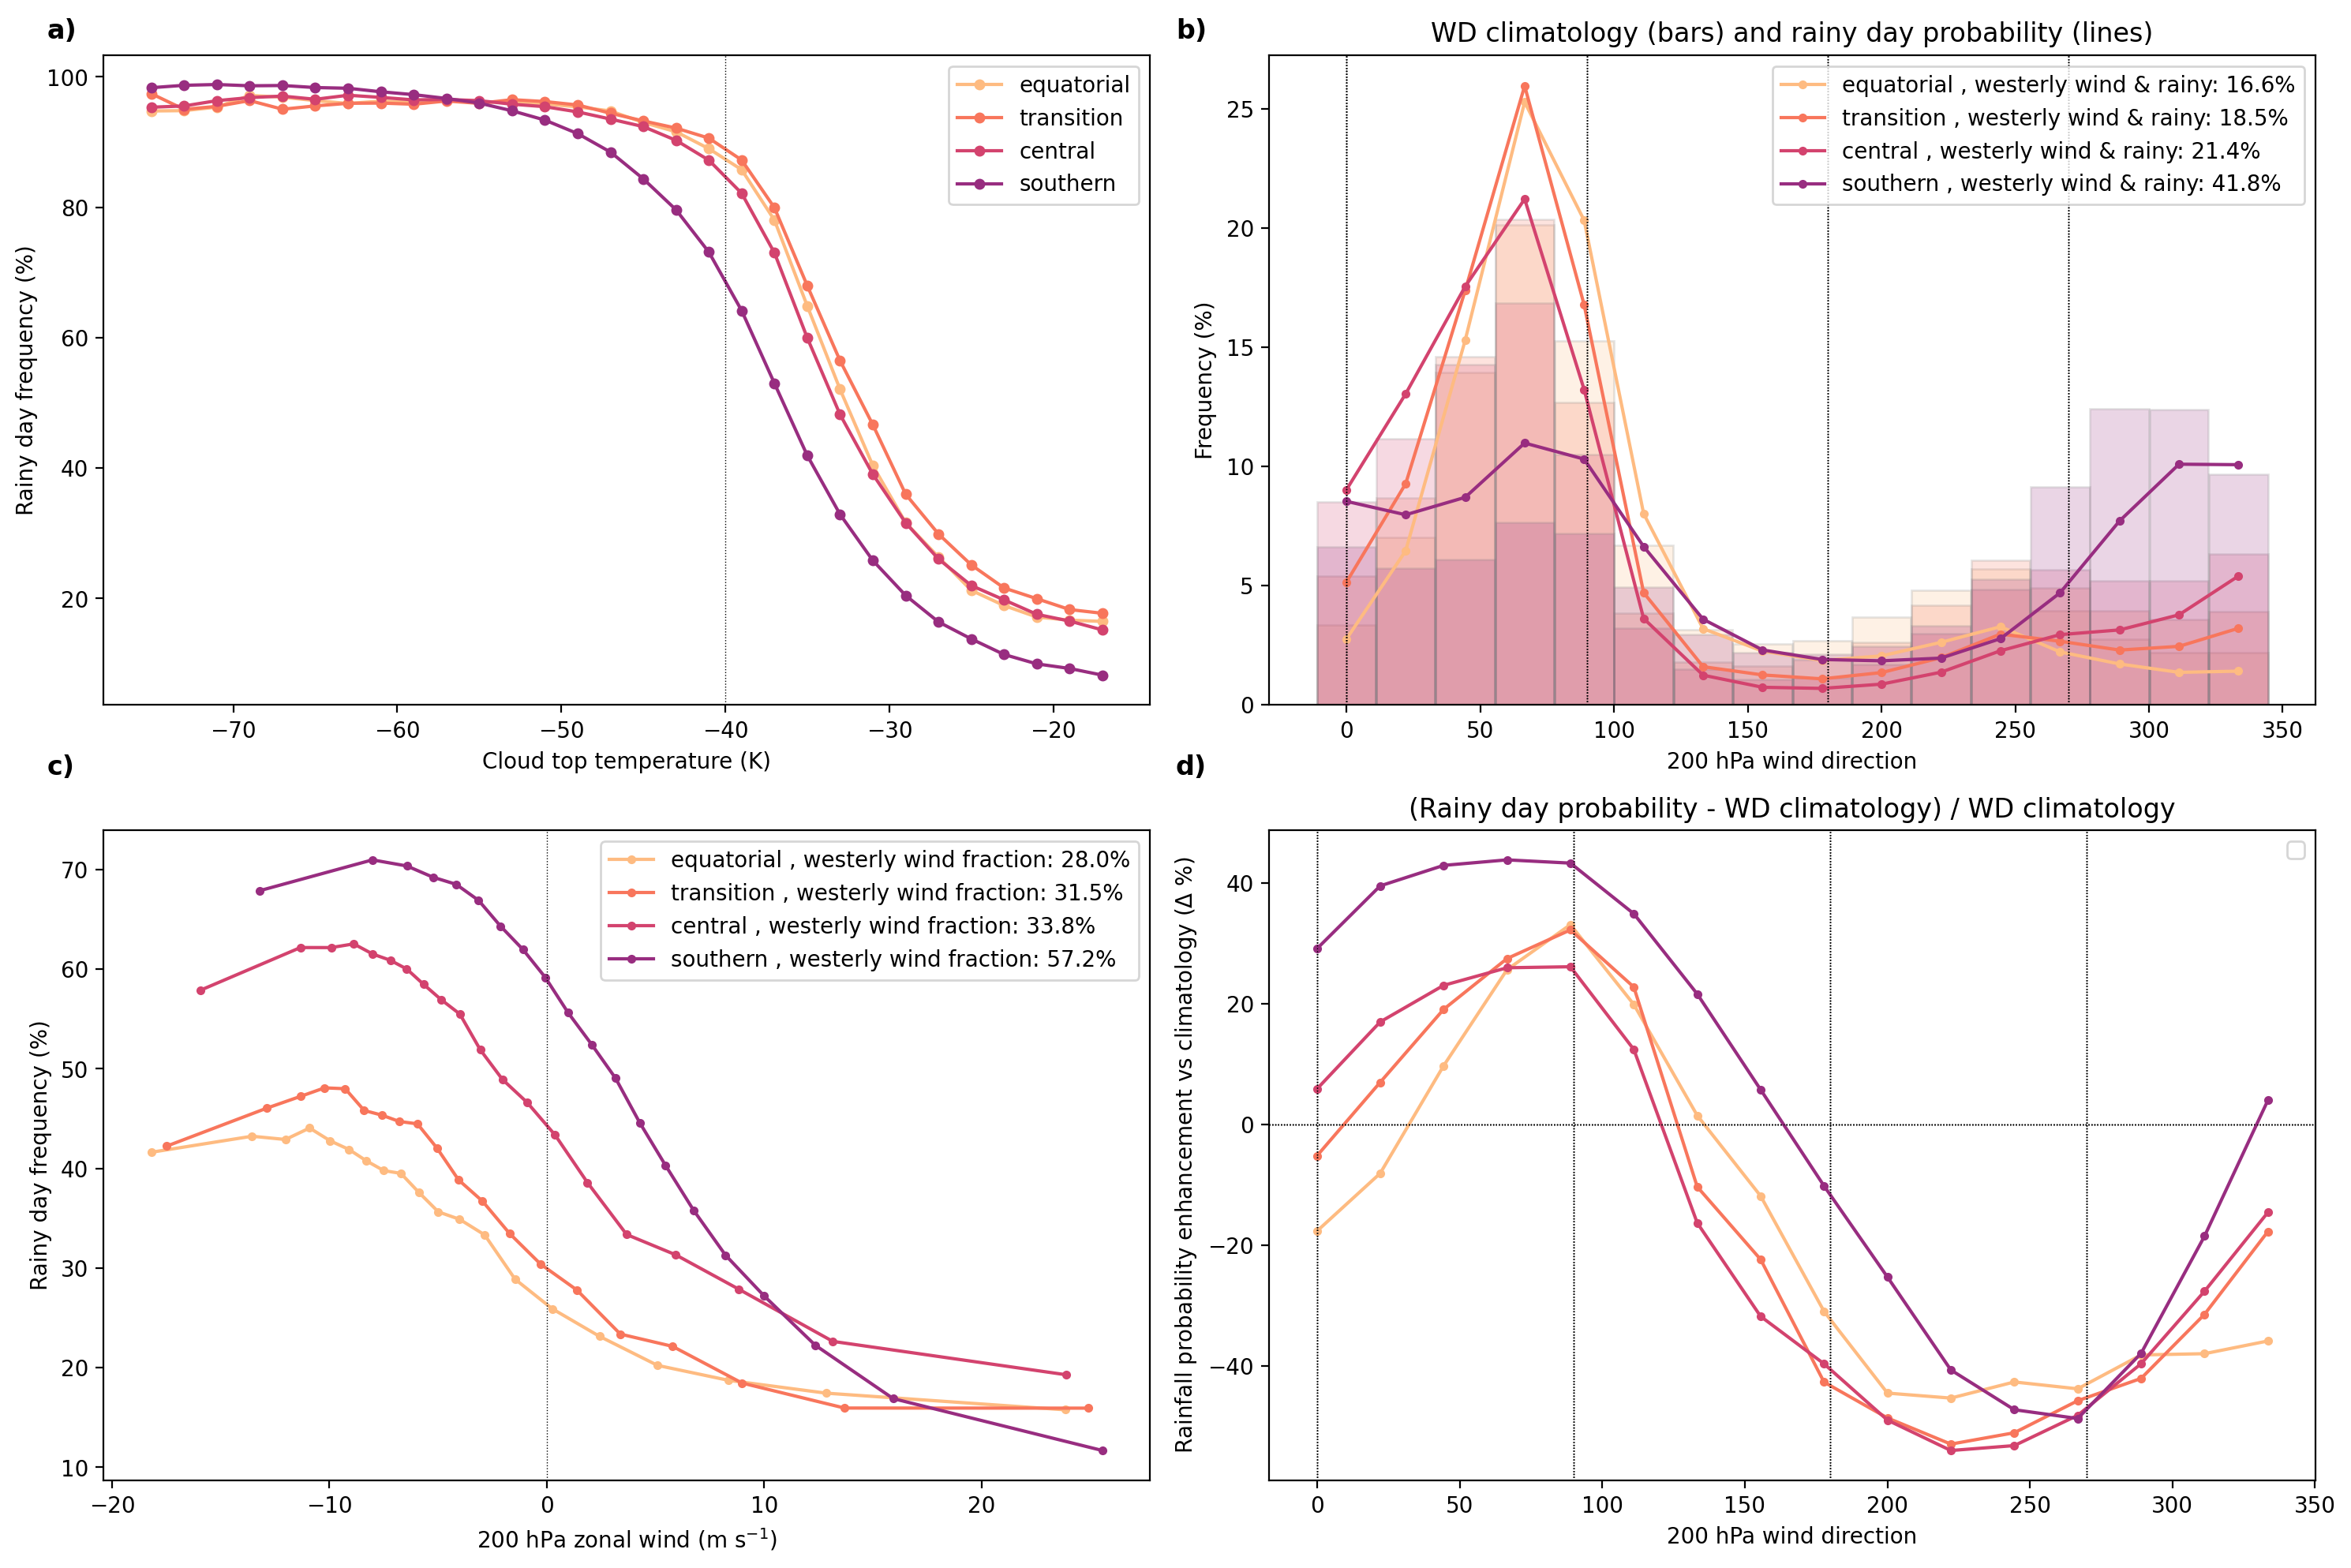

In [45]:
from endgame import hist2d

f = plt.figure(figsize=(15,10), dpi=200)
#ax = f.add_subplot(2,2,ids+1)
ax2 = f.add_subplot(221)
ax4 = f.add_subplot(223)
ax5 = f.add_subplot(224)
ax3 = f.add_subplot(222)
#ax3 = f.add_subplot(133)
for ids, r in enumerate(regions.keys()):
    
    alls = regions[r]
    doys_s = np.round(alls[1][0])
    doys_e = np.round(alls[1][1])
    era_region = u200ca['u'].sel(latitude=slice(alls[0][0], alls[0][1]), time =((u200ca['time.dayofyear']>=doys_s) | (u200ca['time.dayofyear']<=doys_e))).where((topo_on_g>2000))
    chirps_region = cau200.sel(latitude=slice(alls[0][0], alls[0][1]), time =((cau200['time.dayofyear']>=doys_s) | (cau200['time.dayofyear']<=doys_e))).where((topo_on_g>2000))
    
    era_region_gr = u200gr.sel(latitude=slice(alls[0][0], alls[0][1]), time =((u200gr['time.dayofyear']>=doys_s) | (u200gr['time.dayofyear']<=doys_e))).where((topo_on_g>2000))
    grid_region = grid200.sel(latitude=slice(alls[0][0], alls[0][1]), time =((grid200['time.dayofyear']>=doys_s) | (grid200['time.dayofyear']<=doys_e))).where((topo_on_g>2000))

    mask = np.isfinite(era_region) #& (chirps_region > 0.01) 
    mask_gr = np.isfinite(era_region_gr) & (grid_region < -15)
    #xbins = np.arange(-18,19,2)
    #ipdb.set_trace()
    xbins = np.percentile(era_region.values[mask], [0.1]+list(np.arange(5,96,5))+[99.9])
    
    cbins = np.arange(-80,-10,2)#np.percentile(grid_region.values[mask_gr], [0.1]+list(np.arange(5,96,5))+[99.9])
    
#     dic = hist2d.var2_binning_mean(era_region.values[mask],chirps_region.values[mask],xbins)
    chperc = np.percentile(era_region_gr.values[mask_gr], 90)
    dicgrid = hist2d.var2_binning_threshold(grid_region.values[mask_gr], era_region_gr.values[mask_gr], cbins, gt=1, lt=None)
    
#     ax.plot(dic['xbins'], dic['y'], marker='o', markersize=4, color='lightgrey')
    
    stx = 2
    ste = -2
    
#     intercept, slope, r_value,rpearson, ppearson = weighted_regress(dic['xbins'][stx:ste],dic['y'][stx:ste],dic['ycount'][stx:ste] )
#     ax.plot(dic['xbins'][stx:ste], dic['y'][stx:ste], label=r+'| slope: '+str(np.round(slope,2)), marker='o', markersize=4, color=colord[ids])
#     ax.plot(dic['xbins'][stx:ste],slope*(dic['xbins'][stx:ste])+intercept, linestyle='dashed', color='k', linewidth=0.5)
    
    fraq = np.array(dicgrid['y'][stx:ste])*100
    ax2.plot(dicgrid['xbins'][stx:ste], fraq, marker='o', markersize=4, color=colord[ids], label=r)

    

    #ax.set_xlabel('200hPa zonal wind (m s$^{-1}$)')
    ax2.set_xlabel('Cloud top temperature (K)')
   # ax.set_ylabel('Mean rainfall intensity (mm day$^{-1}$)')
    ax2.set_ylabel('Rainy day frequency (%)')
    
##############    
    
    wdaug = wd.sel(latitude=slice(alls[0][0], alls[0][1]), time =((u200ca['time.dayofyear']>=doys_s) | (u200ca['time.dayofyear']<=doys_e))).where((topo_on_g>2000))+180-11.25
    wsaug = ws.sel(latitude=slice(alls[0][0], alls[0][1]), time =((u200ca['time.dayofyear']>=doys_s) | (u200ca['time.dayofyear']<=doys_e))).where((topo_on_g>2000))
    caaug = cau200.sel(latitude=slice(alls[0][0], alls[0][1]), time =((cau200['time.dayofyear']>=doys_s) | (cau200['time.dayofyear']<=doys_e))).where((topo_on_g>2000))
    era_region = u200ca['u'].sel(latitude=slice(alls[0][0], alls[0][1]), time =((u200ca['time.dayofyear']>=doys_s) | (u200ca['time.dayofyear']<=doys_e))).where((topo_on_g>2000))
    
    alim = 1
    mean, bins, binnb = stats.binned_statistic(wdaug.values.flatten(), ((caaug.values.flatten()>=alim)).astype(int), bins=np.arange(-11.25,361,22.24), statistic=np.nansum)
    mbins = bins[0:-1] + (bins[1::]-bins[0:-1])/2

    meanz, binsz, binnbz = stats.binned_statistic(wdaug.values.flatten(), (caaug.values.flatten()>=0).astype(int), bins=np.arange(-11.25,361,22.24), statistic=np.nansum)
    mbins = bins[0:-1] + (bins[1::]-bins[0:-1])/2
    
    
#     plt.bar(mbins, meanz/np.sum(meanz)*100, width=(bins[1::]-bins[0:-1]-1), edgecolor='k', label='all day frequency', color='grey')
#     plt.bar(mbins, mean/np.sum(mean)*100, width=(bins[1::]-bins[0:-1]-1), edgecolor='k', label='rainy day frequency', color='lightblue', alpha=0.7)
    
    ax3.plot(mbins,mean/np.sum(mean)*100, marker='o', markersize=3, color=colord[ids], label=r+' , westerly wind & rainy: '+str(np.round((np.sum((caaug.values>=1) & (era_region.values>0)) / np.sum((caaug.values>=1)))*100, 1))+'%')
    ax3.bar(mbins,meanz/np.sum(meanz)*100, color=colord[ids], edgecolor='grey', alpha=0.2, width=22)
    
    plt.title('WD climatology (bars) and rainy day probability (lines)')
    ax3.axvline(90, color='k', linewidth=0.5, linestyle='dotted')
    ax3.axvline(180, color='k', linewidth=0.5, linestyle='dotted')
    ax3.axvline(270, color='k', linewidth=0.5, linestyle='dotted')
    ax3.axvline(0, color='k', linewidth=0.5, linestyle='dotted')

    ax3.set_ylabel('Frequency (%)')
    ax3.set_xlabel('200 hPa wind direction')
    plt.legend()

########################
    cbars = ['lightblue']*16
    dat = ((mean/np.sum(mean) - meanz/np.sum(meanz))/(meanz/np.sum(meanz)))*100
    
    bposi = np.where(dat < 0)
    cbars = np.array(cbars)
    cbars[bposi] = 'tomato'

    #plt.bar(mbins,dat , width=(bins[1::]-bins[0:-1]-1), edgecolor='k', color=cbars)
    
    ax5.plot(mbins,dat, marker='o', markersize=3, color=colord[ids])
    
    #plt.bar(mbins, mean/np.sum(mean), width=(bins[1::]-bins[0:-1]), edgecolor='k')
    ax5.set_title('(Rainy day probability - WD climatology) / WD climatology')
    ax5.axvline(90, color='k', linewidth=0.5, linestyle='dotted')
    ax5.axvline(180, color='k', linewidth=0.5, linestyle='dotted')
    ax5.axvline(270, color='k', linewidth=0.5, linestyle='dotted')
    ax5.axvline(0, color='k', linewidth=0.5, linestyle='dotted')
    ax5.axhline(0, color='k', linewidth=0.5, linestyle='dotted')

    ax5.set_ylabel(r'Rainfall probability enhancement vs climatology ($\Delta$ %)')
    ax5.set_xlabel('200 hPa wind direction')
    
    
#########################
    cbins =  np.percentile(era_region.values[mask], [0.1]+list(np.arange(5,96,5))+[99.9]) #np.percentile(era_region.values[mask], np.arange(0,101,5))
    dicgrid = hist2d.var2_binning_threshold(era_region.values[mask],chirps_region.values[mask], cbins, gt=1, lt=None)
    
    ax4.plot(dicgrid['xbins'], np.array(dicgrid['y'])*100, marker='o', markersize=3, color=colord[ids], label=r+' , westerly wind fraction: '+str(np.round(np.sum(era_region.values[mask]>0) / np.sum(np.isfinite(era_region.values[mask]))*100, 1))+'%')
    #ax3.plot(dicgrid['xbins'], np.arange(0,101,5), marker='o', markersize=3, color='k')
    #+' : '+str(np.round(np.sum(era_region.values[mask]>0) / np.sum(np.isfinite(era_region.values[mask]))*100, 1))+'%'
    ax4.set_xlabel('200 hPa zonal wind (m s$^{-1}$)')
    ax4.set_ylabel('Rainy day frequency (%)')
    
    
    
ax.legend(fontsize=8)
ax2.axvline(-40, linestyle='dotted', linewidth=0.5, color='k')
ax3.axvline(0, linestyle='dotted', color='k', linewidth=0.5)
ax4.axvline(0, linestyle='dotted', color='k', linewidth=0.5)
#ax2.legend(fontsize=8)
#ax2.set_ylim(-50,-25)
ax2.legend()
ax3.legend()
ax5.legend()
ax4.legend()
#plt.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/paper/figS01.jpg')

plt.tight_layout()
plt.annotate('a)', xy=(0.02, 0.97), xytext=(0, 4), size=12, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points', fontweight='bold')
plt.annotate('b)', xy=(0.5, 0.97), xytext=(0, 4), size=12, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points', fontweight='bold')

plt.annotate('c)', xy=(0.02, 0.5), xytext=(0, 4), size=12, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points', fontweight='bold')
plt.annotate('d)', xy=(0.5, 0.5), xytext=(0, 4), size=12, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points', fontweight='bold')

f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/paper/cloudT_rainfall_windDirection_1mm_3x.jpg')

In [52]:
import windrose 
from windrose import WindroseAxes
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import numpy as np
from matplotlib.projections import register_projection

register_projection(WindroseAxes)

cloudy cases 209370
all cases 626934
nb years 34
cloudy cases 165605
all cases 461912
nb years 34
cloudy cases 455955
all cases 948024
nb years 34
cloudy cases 686001
all cases 1391668
nb years 34


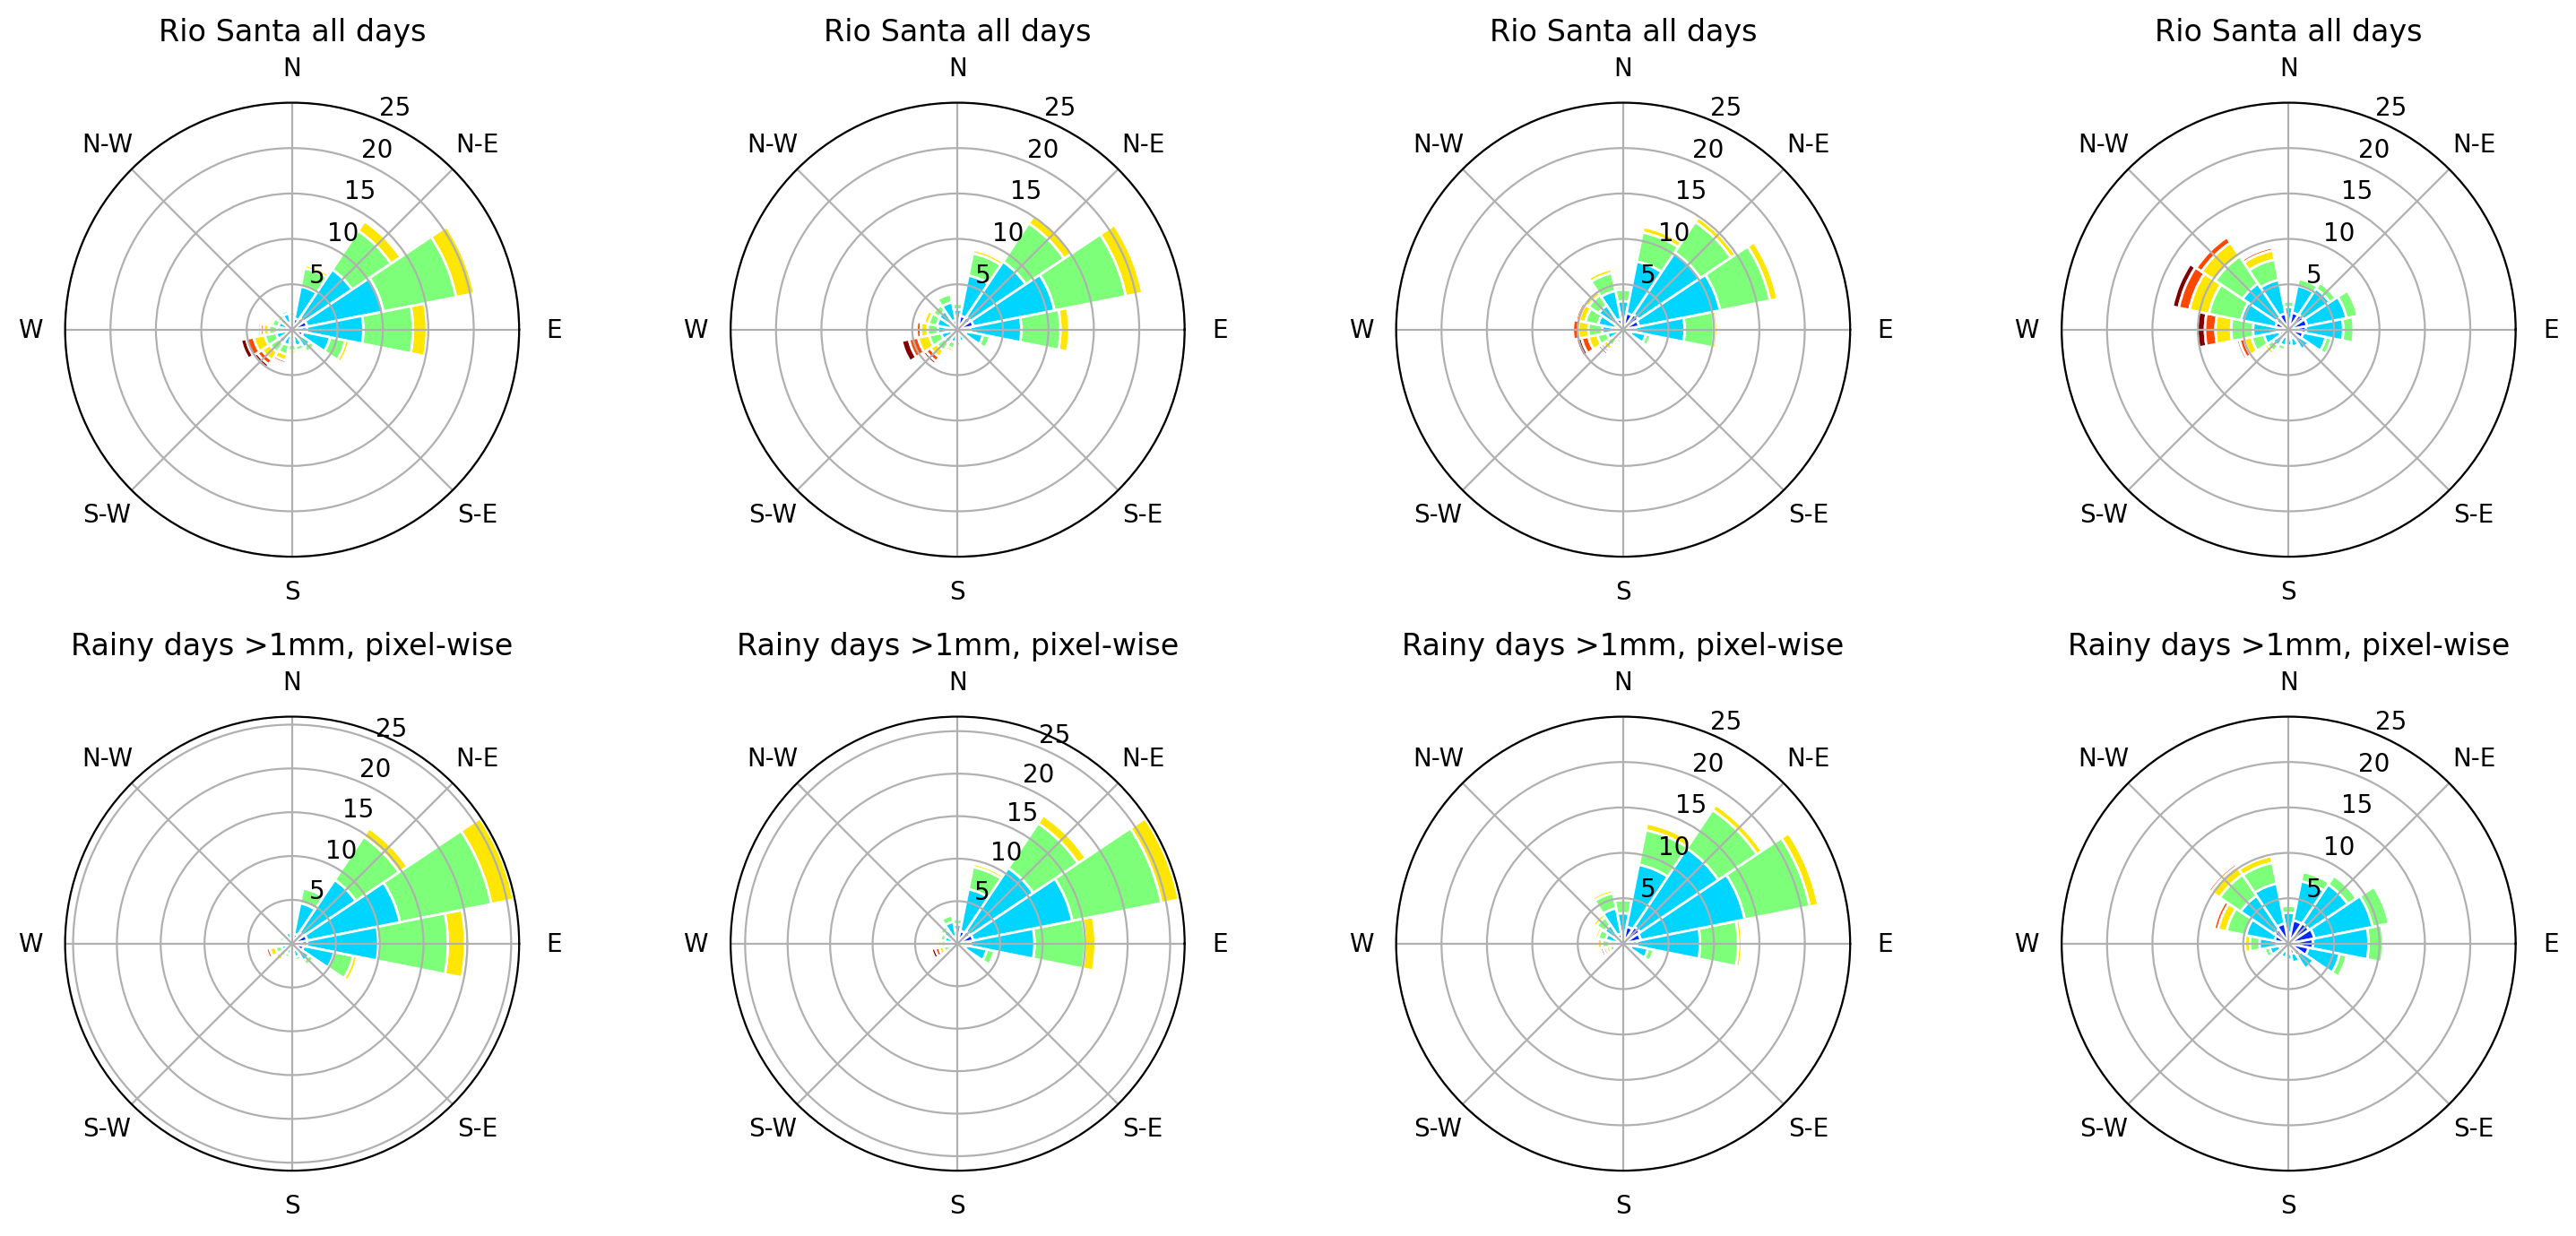

In [63]:
f = plt.figure(figsize=(15,7), dpi=200)

for ids, r in enumerate(regions.keys()):
    
    alls = regions[r]
    doys_s = np.round(alls[1][0])
    doys_e = np.round(alls[1][1])

    wdaug = wd.sel(latitude=slice(alls[0][0], alls[0][1]), time =((u200ca['time.dayofyear']>=doys_s) | (u200ca['time.dayofyear']<=doys_e))).where((topo_on_g>2000))+180-11.25
    wsaug = ws.sel(latitude=slice(alls[0][0], alls[0][1]), time =((u200ca['time.dayofyear']>=doys_s) | (u200ca['time.dayofyear']<=doys_e))).where((topo_on_g>2000))
    caaug = cau200.sel(latitude=slice(alls[0][0], alls[0][1]), time =((cau200['time.dayofyear']>=doys_s) | (cau200['time.dayofyear']<=doys_e))).where((topo_on_g>2000))
    ax = f.add_subplot(2,4,ids+1, projection='windrose')

    ws_array = np.array(wsaug.values.flatten())
    wd_array = np.array(wdaug.values.flatten())

    ws_array = ws_array[np.isfinite(ws_array)]
    wd_array = wd_array[np.isfinite(wd_array)]


    color_s = ['red', 'blue', 'lime', 'yellow', 'violet', 'aqua', 'pink', 'grey', 'darkred', 'navy', 'green']

    ax = WindroseAxes.from_ax(ax)
    ax.bar(wd_array, ws_array, normed=True, opening=1.0, edgecolor='white', bins=[0,2,5,10,15,20,25])
    ax.set_yticks(np.arange(5, 26, step=5))
    ax.set_yticklabels(np.arange(5, 26, step=5))

    #ax.set_legend(title = 'Wind Speed in m/s', bbox_to_anchor=(1.05, 1), loc='upper left', handles = color_s, borderaxespad=0.)
    plt.title('Rio Santa all days')


    ax = f.add_subplot(2,4,ids+5, projection='windrose')

    alim = -15 #puspa
    blim = 1

    # alim = -20
    # blim = -100

    wdin = wdaug.values[(caaug.values>=blim)]
    wsin = wsaug.values[(caaug.values>=blim)]

    print('cloudy cases', wdin.size)
    print('all cases', ws_array.size)
    print('nb years', np.unique(wdaug['time.year']).size)

    ws_array = np.array(wsin.flatten())
    wd_array = np.array(wdin.flatten())

    ax = WindroseAxes.from_ax(ax)
    ax.bar(wd_array, ws_array, normed=True, opening=1.0, edgecolor='white', bins=[0,2,5,10,15,20,25])
    ax.set_yticks(np.arange(5, 26, step=5))
    ax.set_yticklabels(np.arange(5, 26, step=5))
    plt.title('Rainy days >1mm, pixel-wise')


    #ax.set_legend(title = 'Wind Speed in Knots', bbox_to_anchor=(1.05, 1), loc='upper left', handles = color_s, borderaxespad=0.)
    # if mon == 1:
    #     plt.title('Difference WD frequency rainy days vs all days')

plt.tight_layout()
plt.show()
#f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/windrose_GRIDSAT_Aug-Sep_RD1mm_topoLT4500_GT-20.jpg')

cloudy cases 181197
all cases 626934
nb years 34
cloudy cases 143349
all cases 461912
nb years 34
cloudy cases 384580
all cases 948024
nb years 34
cloudy cases 554733
all cases 1391668
nb years 34


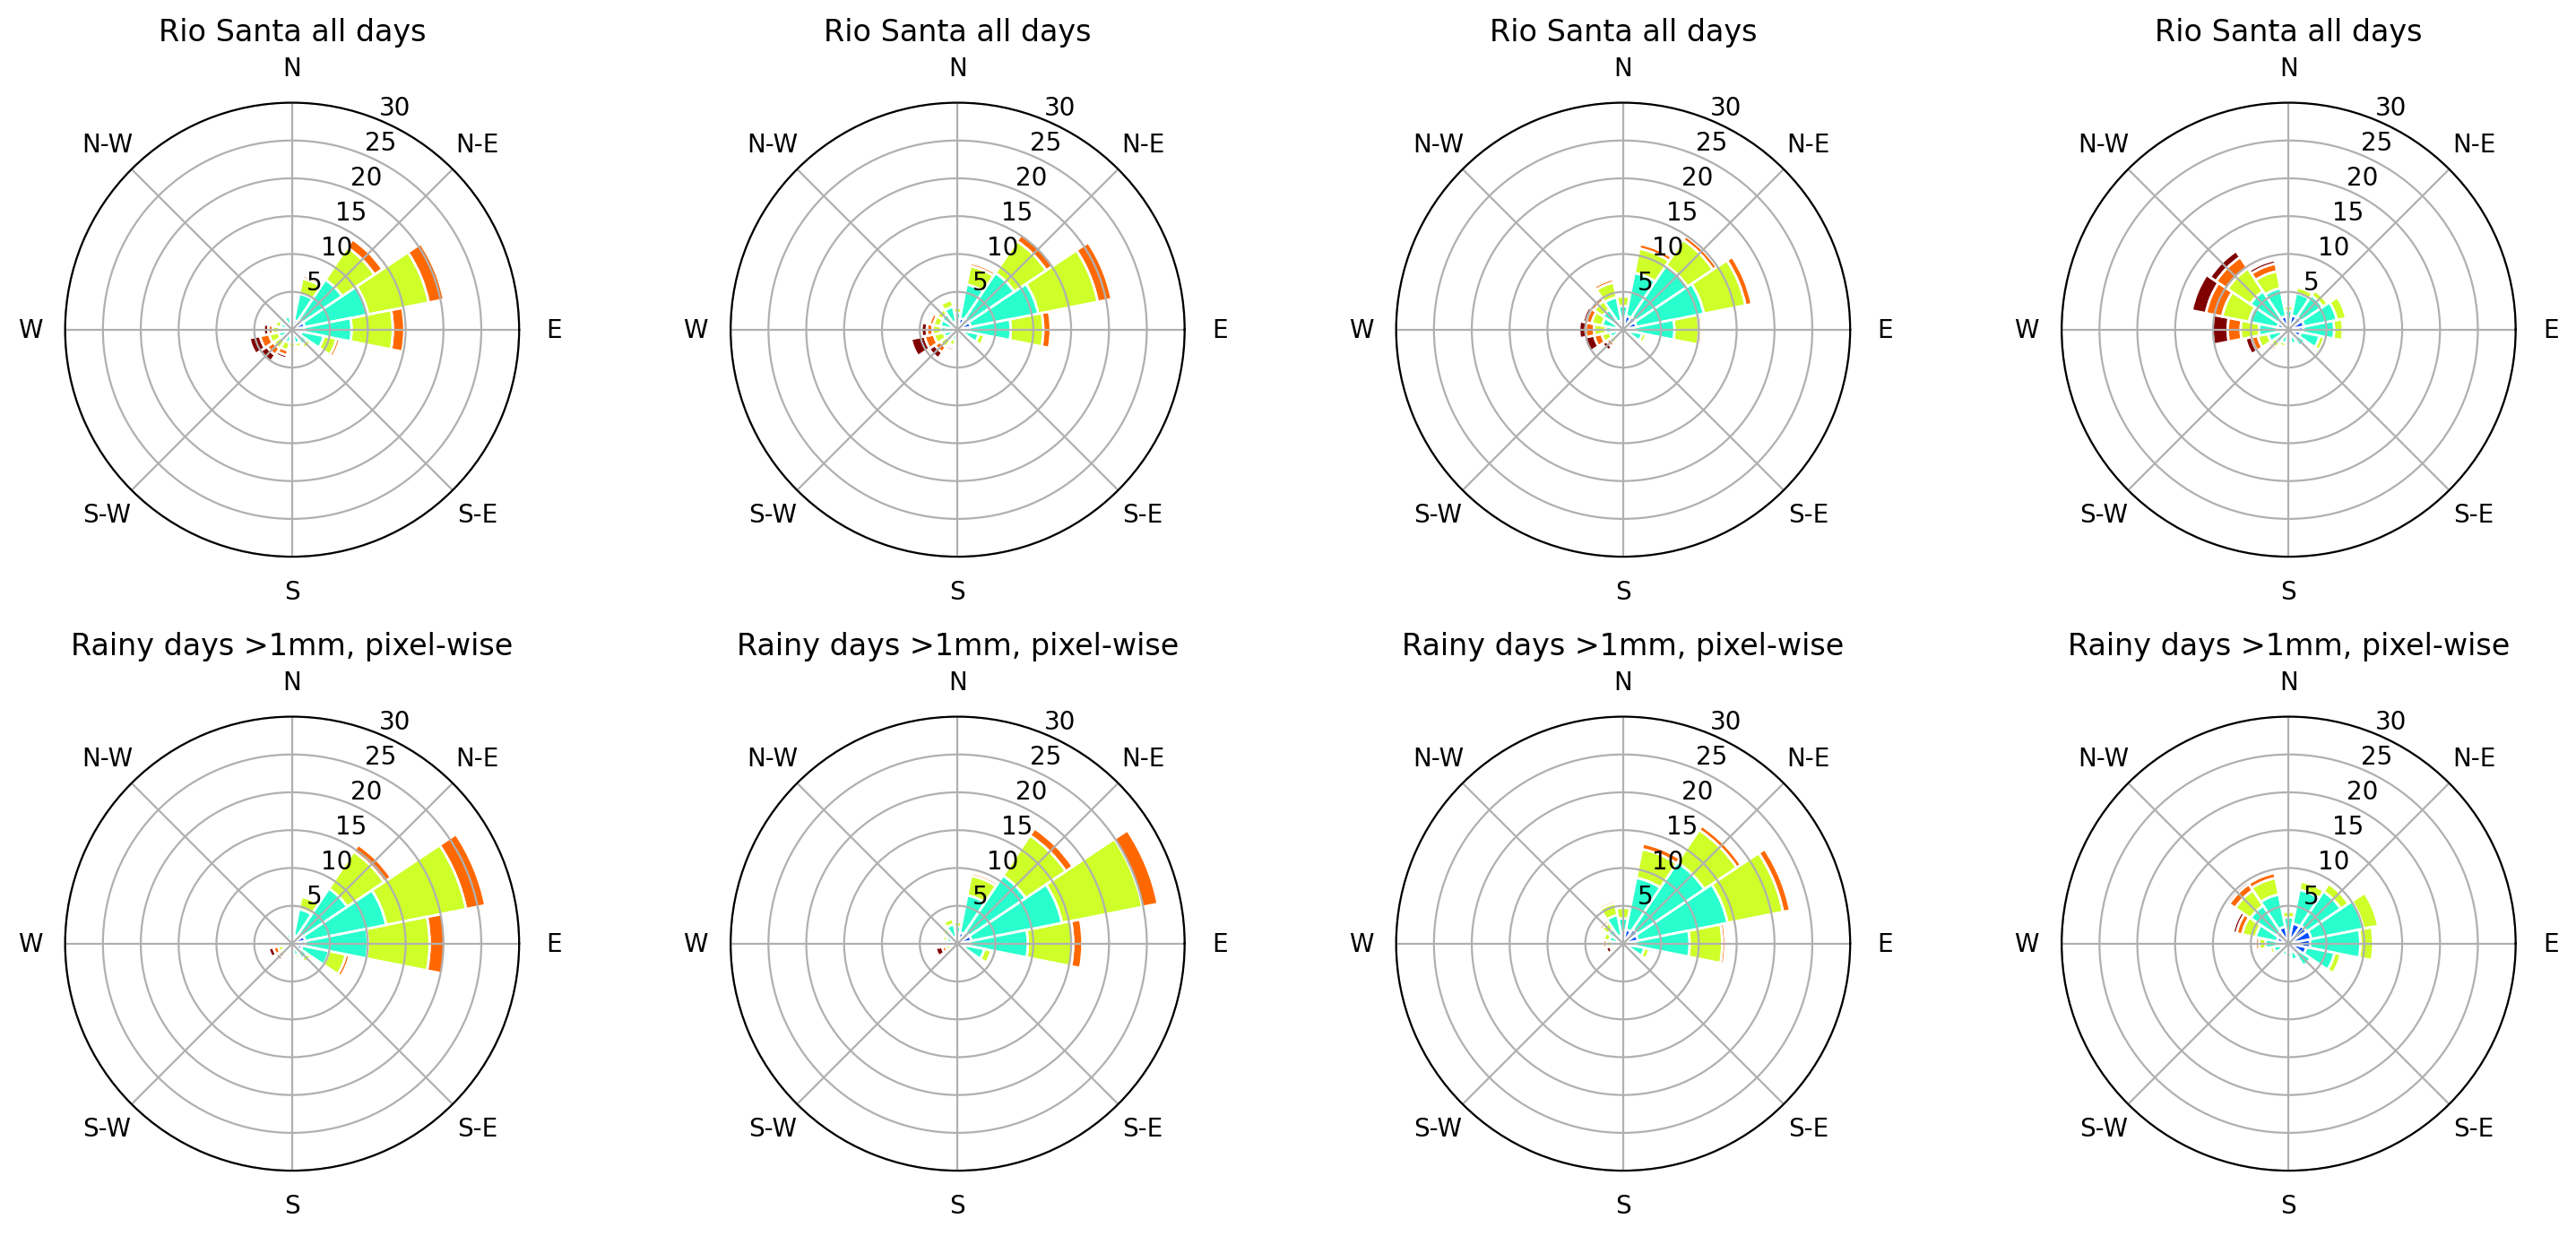

In [62]:
f = plt.figure(figsize=(15,7), dpi=200)

for ids, r in enumerate(regions.keys()):
    
    alls = regions[r]
    doys_s = np.round(alls[1][0])
    doys_e = np.round(alls[1][1])

    wdaug = wd.sel(latitude=slice(alls[0][0], alls[0][1]), time =((u200ca['time.dayofyear']>=doys_s) | (u200ca['time.dayofyear']<=doys_e))).where((topo_on_g>2000))+180-11.25
    wsaug = ws.sel(latitude=slice(alls[0][0], alls[0][1]), time =((u200ca['time.dayofyear']>=doys_s) | (u200ca['time.dayofyear']<=doys_e))).where((topo_on_g>2000))
    caaug = cau200.sel(latitude=slice(alls[0][0], alls[0][1]), time =((cau200['time.dayofyear']>=doys_s) | (cau200['time.dayofyear']<=doys_e))).where((topo_on_g>2000))
    ax = f.add_subplot(2,4,ids+1, projection='windrose')

    ws_array = np.array(wsaug.values.flatten())
    wd_array = np.array(wdaug.values.flatten())

    ws_array = ws_array[np.isfinite(ws_array)]
    wd_array = wd_array[np.isfinite(wd_array)]


    color_s = ['red', 'blue', 'lime', 'yellow', 'violet', 'aqua', 'pink', 'grey', 'darkred', 'navy', 'green']

    ax = WindroseAxes.from_ax(ax)
    ax.bar(wd_array, ws_array, normed=True, opening=1.0, edgecolor='white', bins=[0,2,5,10,15,20])
    ax.set_yticks(np.arange(5, 31, step=5))
    ax.set_yticklabels(np.arange(5, 31, step=5))

    #ax.set_legend(title = 'Wind Speed in m/s', bbox_to_anchor=(1.05, 1), loc='upper left', handles = color_s, borderaxespad=0.)
    plt.title(r+': all days')


    ax = f.add_subplot(2,4,ids+5, projection='windrose')

    alim = -15 #puspa
    blim = 2

    # alim = -20
    # blim = -100

    wdin = wdaug.values[(caaug.values>=blim)]
    wsin = wsaug.values[(caaug.values>=blim)]

    print('cloudy cases', wdin.size)
    print('all cases', ws_array.size)
    print('nb years', np.unique(wdaug['time.year']).size)

    ws_array = np.array(wsin.flatten())
    wd_array = np.array(wdin.flatten())

    ax = WindroseAxes.from_ax(ax)
    ax.bar(wd_array, ws_array, normed=True, opening=1.0, edgecolor='white', bins=[0,2,5,10,15,20])
    ax.set_yticks(np.arange(5, 31, step=5))
    ax.set_yticklabels(np.arange(5, 31, step=5))
    plt.title('Rainy days > 1mm')


    #ax.set_legend(title = 'Wind Speed in Knots', bbox_to_anchor=(1.05, 1), loc='upper left', handles = color_s, borderaxespad=0.)
    # if mon == 1:
    #     plt.title('Difference WD frequency rainy days vs all days')

plt.tight_layout()
plt.show()
#f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/windrose_GRIDSAT_Aug-Sep_RD1mm_topoLT4500_GT-20.jpg')